## Import des API et acces au serveur de Earth Engine


In [1]:
import ee
import geemap.core as geemap

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='your project name')

## Configuration des images Landsat 5 et 8 pour suivre l'évolution de la surface d'eau de la mer morte entre 1984 et 2025


#### Traitement Landsat 5 images 1984-2013

In [3]:
# Définir ta zone d'intérêt
roi = ee.Geometry.Polygon([[
    [35.17169069434731, 30.817648694989774],
    [35.17169069434731, 31.88039146117379],
    [35.76087721064122, 31.88039146117379],
    [35.76087721064122, 30.817648694989774],
    [35.17169069434731, 30.817648694989774]
]])

# Paramètres - Période Landsat 5 (1984-2012)
years = list(range(1984, 2014))
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def apply_qa_mask_landsat5(image):
    """
    Applique le masque de qualité pour Landsat 5 Collection 2 SR
    Utilise la bande QA_PIXEL pour exclure pixels Fill, nuages, ombres de nuages, neige,
    et le bit 2 (unused) pour s'assurer qu'il est bien à 0.
    """
    qa = image.select('QA_PIXEL')

    # Définition des bits à masquer
    fill_bit = 1 << 0          # bit 0 : Fill
    dilated_cloud_bit = 1 << 1 # bit 1 : Cloud
    unused_bit = 1 << 2        # bit 2 : Unused
    cloud_shadow_bit = 1 << 3  # bit 3 : Cloud shadow
    snow_bit = 1 << 4          # bit 4 : Snow/Ice

    # Masques (vrai = pixel valide)
    fill_mask = qa.bitwiseAnd(fill_bit).eq(0)
    dilated_cloud_mask = qa.bitwiseAnd(dilated_cloud_bit).eq(0)
    unused_mask = qa.bitwiseAnd(unused_bit).eq(0)
    cloud_shadow_mask = qa.bitwiseAnd(cloud_shadow_bit).eq(0)
    snow_mask = qa.bitwiseAnd(snow_bit).eq(0)

    # CORRECTION: Utiliser les méthodes Earth Engine pour combiner les masques
    combined_mask = fill_mask \
        .And(dilated_cloud_mask) \
        .And(unused_mask) \
        .And(cloud_shadow_mask) \
        .And(snow_mask)

    # Application du masque sur l'image entière
    return image.updateMask(combined_mask)

# Fonction pour traiter les bandes SR de Landsat 5
def process_landsat5_sr_bands(image):
    """
    Traite les bandes SR de Landsat 5: applique calibration, masque QA, et contraint les valeurs
    """
    # Appliquer le masque QA
    image_masked = apply_qa_mask_landsat5(image)

    # Bandes Landsat 5 TM (Thematic Mapper)
    sr_bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']

    # CORRECTION: Traiter toutes les bandes en une seule fois
    calibrated_image = image_masked.select(sr_bands) \
        .multiply(0.0000275) \
        .add(-0.2) \
        .clamp(0, 1)  # Remplace les where(lt(0), 0) et where(gt(1), 1)

    return calibrated_image

# Fonction pour calculer le pourcentage de pixels valides pour Landsat 5
def calculate_valid_pixel_percentage_landsat5(image, geometry):
    """
    Calcule le pourcentage de pixels valides pour Landsat 5
    """
    # Utiliser la bande verte (SR_B2) comme référence
    valid_mask = image.select('SR_B2').mask()

    valid_sum = valid_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,  # Résolution Landsat 5: 30m
        maxPixels=1e13,
        bestEffort=True
    ).get('SR_B2')

    total_sum = ee.Image.constant(1).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=30,
        maxPixels=1e13,
        bestEffort=True
    ).get('constant')

    percentage = ee.Number(valid_sum).divide(ee.Number(total_sum)).multiply(100)

    return percentage

# Fonction pour calculer NDWI avec Landsat 5
def calculate_ndwi_landsat5(image):
    """
    Calcule NDWI avec les bandes Landsat 5
    Formule NDWI: (Green - NIR) / (Green + NIR)
    Pour Landsat 5: Green = SR_B2, NIR = SR_B4
    """
    green = image.select('SR_B2')  # Band 2 = Green
    nir = image.select('SR_B4')    # Band 4 = NIR

    # Calcul NDWI
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')

    return ndwi

# Fonction principale pour Landsat 5
def process_landsat5_ndwi(year, month, path=174, row=38):
    """
    Calcule NDWI avec Landsat 5 pour une période spécifique
    """
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    # Charger la collection Landsat 5
    collection = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
                  .filterDate(start, end)
                  .filterBounds(roi)
                  .filter(ee.Filter.eq('WRS_PATH', path))
                  .filter(ee.Filter.eq('WRS_ROW', row)))

    # Vérifier le nombre d'images
    count = collection.size().getInfo()

    if count == 0:
        print(f"  ❌ Aucune image Landsat 5 trouvée pour {year}-{month:02d} sur la tuile {path}/{row}")
        return []

    print(f"  📊 {count} images Landsat 5 trouvées pour {year}-{month:02d} (tuile {path}/{row})")

    # Convertir la collection en liste
    image_list = collection.toList(count)

    results_month = []

    # Traiter chaque image
    for i in range(count):
        image = ee.Image(image_list.get(i))
        cloud_cover = image.get('CLOUD_COVER').getInfo() if image.get('CLOUD_COVER') else 'N/A'
        image_id = image.get('system:index').getInfo()

        # Récupérer la date exacte
        image_date = image.date().format('YYYY-MM-dd').getInfo()

        cloud_info = f"cloud: {cloud_cover:.2f}%" if cloud_cover != 'N/A' else "cloud: N/A"
        print(f"    🖼️  Traitement image {i+1}/{count}: {image_date}, ID {image_id}, {cloud_info}")

        try:
            # Appliquer le clipping sur la ROI
            image_clipped = image.clip(roi)

            # Traiter les bandes SR
            processed_image = process_landsat5_sr_bands(image_clipped)

            # Calculer le pourcentage de pixels valides
            valid_percentage = calculate_valid_pixel_percentage_landsat5(processed_image, roi)
            valid_percentage_value = valid_percentage.getInfo()

            print(f"      📈 Pourcentage de pixels valides: {valid_percentage_value:.2f}%")

            # Vérifier si l'image est utilisable (> 80% de pixels valides)
            if valid_percentage_value < 75:
                print(f"      ❌ Image rejetée: seulement {valid_percentage_value:.2f}% de pixels valides (< 80%)")
                continue

            # Calculer NDWI avec Landsat 5
            ndwi = calculate_ndwi_landsat5(processed_image)

            # Seuillage NDWI > 0 pour masque d'eau
            water_mask = ndwi.gt(0.05).selfMask()

            # Vectoriser
            vectors = water_mask.reduceToVectors(
                geometry=roi,
                geometryType='polygon',
                scale=30,  # Résolution Landsat 5: 30m
                labelProperty='label',
                maxPixels=1e13
            )

            # Créer la composition colorée (Vraies couleurs)
            rgb_image = ee.Image.cat([
                processed_image.select('SR_B3'),  # Rouge
                processed_image.select('SR_B2'),  # Vert
                processed_image.select('SR_B1')   # Bleu
            ]).rename(['red', 'green', 'blue'])

            # Ajuster la visualisation
            rgb_image = rgb_image.visualize(**{
                'min': 0,
                'max': 0.3,
                'gamma': 1.4
            })

            # Ajouter les informations au résultat
            result_data = {
                'year': year,
                'month': month,
                'date': image_date,
                'image_id': image_id,
                'valid_pixel_percentage': valid_percentage_value,
                'ndwi': ndwi,
                'binary_water': water_mask,
                'water_vectors': vectors,
                'rgb_image': rgb_image,
                'sensor': 'Landsat5_TM'
            }

            # Ajouter cloud cover si disponible
            if cloud_cover != 'N/A':
                result_data['cloud_cover'] = cloud_cover

            results_month.append(result_data)

            print(f"      ✅ Image Landsat 5 acceptée ({valid_percentage_value:.2f}% pixels valides)")

        except Exception as e:
            print(f"      ❌ Erreur lors du traitement de l'image {i+1}: {str(e)}")
            continue

    print(f"  📋 {len(results_month)} images Landsat 5 valides sur {count} pour {year}-{month:02d}")
    return results_month

# Fonction pour traiter toutes les images Landsat 5
def process_all_landsat5_images():
    """
    Traite toutes les images Landsat 5 pour la période 1984-2012
    """
    all_results = []

    print("Début du traitement complet avec Landsat 5...")
    print("Période: 1984-2012")
    print("Capteur: TM (Thematic Mapper, 30m de résolution)")
    print("Critères: >80% de pixels valides requis")
    print("-" * 60)

    for y in years:
        for m in months:
            print(f"\n🎯 Traitement Landsat 5 - {y}-{m:02d}...")

            # Appel pour Landsat 5
            monthly_results = process_landsat5_ndwi(y, m, path=174, row=38)

            all_results.extend(monthly_results)

            print(f"📊 {y}-{m:02d}: {len(monthly_results)} images Landsat 5 traitées avec succès")

    print(f"\n" + "="*60)
    print(f"Traitement Landsat 5 terminé. {len(all_results)} images traitées avec succès au total.")

    # Statistiques détaillées
    if all_results:
        print(f"\n📈 Statistiques détaillées Landsat 5:")

        # Par année
        for year in years:
            year_results = [r for r in all_results if r['year'] == year]
            if year_results:
                months_with_data = len(set(r['month'] for r in year_results))
                dates_count = len(set(r['date'] for r in year_results))
                print(f"  {year}: {len(year_results)} images sur {dates_count} dates différentes ({months_with_data} mois)")

        # Par mois
        print(f"\n📅 Distribution par mois:")
        for month in range(1, 13):
            month_results = [r for r in all_results if r['month'] == month]
            if month_results:
                years_count = len(set(r['year'] for r in month_results))
                print(f"  Mois {month:02d}: {len(month_results)} images sur {years_count} années")

        # Décennies
        print(f"\n📊 Répartition par décennie:")
        decades = {}
        for result in all_results:
            decade = (result['year'] // 10) * 10
            decades[decade] = decades.get(decade, 0) + 1

        for decade in sorted(decades.keys()):
            print(f"  {decade}s: {decades[decade]} images")

    return all_results

# Exécuter le traitement Landsat 5
results_landsat5 = process_all_landsat5_images()

# Afficher un résumé
if results_landsat5:
    print(f"\n📋 Détail des images Landsat 5 traitées (premières 15):")
    print("-" * 80)
    for i, result in enumerate(results_landsat5[:15]):
        cloud_info = f"Cloud: {result.get('cloud_cover', 'N/A'):5.1f}% | " if 'cloud_cover' in result else ""
        print(f"  {i+1:2d}. {result['date']} | "
              f"{cloud_info}"
              f"Valide: {result['valid_pixel_percentage']:5.1f}% | "
              f"Capteur: {result['sensor']} | "
              f"ID: {result['image_id']}")

    if len(results_landsat5) > 15:
        print(f"  ... et {len(results_landsat5) - 15} autres images")

    # Sauvegarder les dates uniques
    unique_dates = sorted(set(r['date'] for r in results_landsat5))
    print(f"\n🗓️  Nombre total de dates Landsat 5 avec données: {len(unique_dates)}")
    if unique_dates:
        print(f"📅 Première date: {min(unique_dates)}")
        print(f"📅 Dernière date: {max(unique_dates)}")

        # Calculer la période couverte
        start_year = min(unique_dates)[:4]
        end_year = max(unique_dates)[:4]
        print(f"📅 Période couverte: {start_year} - {end_year} ({int(end_year) - int(start_year)} années)")
else:
    print("❌ Aucune donnée Landsat 5 trouvée pour la période et la zone spécifiées.")

Début du traitement complet avec Landsat 5...
Période: 1984-2012
Capteur: TM (Thematic Mapper, 30m de résolution)
Critères: >80% de pixels valides requis
------------------------------------------------------------

🎯 Traitement Landsat 5 - 1984-01...
  ❌ Aucune image Landsat 5 trouvée pour 1984-01 sur la tuile 174/38
📊 1984-01: 0 images Landsat 5 traitées avec succès

🎯 Traitement Landsat 5 - 1984-02...
  ❌ Aucune image Landsat 5 trouvée pour 1984-02 sur la tuile 174/38
📊 1984-02: 0 images Landsat 5 traitées avec succès

🎯 Traitement Landsat 5 - 1984-03...
  ❌ Aucune image Landsat 5 trouvée pour 1984-03 sur la tuile 174/38
📊 1984-03: 0 images Landsat 5 traitées avec succès

🎯 Traitement Landsat 5 - 1984-04...
  📊 1 images Landsat 5 trouvées pour 1984-04 (tuile 174/38)
    🖼️  Traitement image 1/1: 1984-04-15, ID LT05_174038_19840415, cloud: 21.00%
      📈 Pourcentage de pixels valides: 74.06%
      ❌ Image rejetée: seulement 74.06% de pixels valides (< 80%)
  📋 0 images Landsat 5 vali

#### Traitement Landsat 8 image 2013 - 2025

In [4]:
# @title
# Définir ta zone d'intérêt
roi = ee.Geometry.Polygon([[
    [35.17169069434731, 30.817648694989774],
    [35.17169069434731, 31.88039146117379],
    [35.76087721064122, 31.88039146117379],
    [35.76087721064122, 30.817648694989774],
    [35.17169069434731, 30.817648694989774]
]])

# Paramètres
years = list(range(2013, 2026))
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Fonction pour appliquer le masque QA_PIXEL
def apply_qa_mask(image):
    """
    Applique le masque QA_PIXEL pour identifier les pixels valides
    """
    qa = image.select('QA_PIXEL')

    # Bits pour Landsat 8/9 QA_PIXEL (selon la documentation)
    # Bit 0: Fill
    # Bit 1: Dilated Cloud
    # Bit 2: Cirrus (High confidence)
    # Bit 3: Cloud
    # Bit 4: Cloud Shadow
    # Bit 5: Snow
    # Bit 6: Clear (0 = cloud or cloud shadow, 1 = clear)
    # Bit 7: Water

    # Masque pour les pixels à exclure:
    fill_mask = qa.bitwiseAnd(1).eq(0)  # Exclure les pixels Fill (bit 0 = 1)
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)  # Exclure les clouds (bit 3 = 1)
    cloud_shadow_mask = qa.bitwiseAnd(1 << 4).eq(0)  # Exclure les cloud shadows (bit 4 = 1)
    cirrus_mask = qa.bitwiseAnd(1 << 2).eq(0)  # Exclure les cirrus (bit 2 = 1)

    # Combiner tous les masques - on garde seulement les pixels qui passent tous les tests
    valid_pixel_mask = fill_mask.And(cloud_mask).And(cloud_shadow_mask).And(cirrus_mask)

    return valid_pixel_mask

# Fonction pour traiter les bandes SR
def process_sr_bands(image):
    """
    Traite les bandes SR: applique calibration, masque QA, et contraint les valeurs
    """
    # Appliquer le masque QA_PIXEL
    valid_mask = apply_qa_mask(image)

    # Sélectionner les bandes SR nécessaires pour NDWI et RGB
    sr_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']

    # Créer une nouvelle image avec les bandes calibrées
    calibrated_band = image.select(sr_bands[0]).multiply(0.0000275).add(-0.2).updateMask(valid_mask)
    calibrated_band = calibrated_band.where(calibrated_band.lt(0), 0)
    calibrated_band = calibrated_band.where(calibrated_band.gt(1), 1)

    calibrated_image = calibrated_band.rename(sr_bands[0])

    for band in sr_bands[1:]:

      calibrated_band = image.select(band).multiply(0.0000275).add(-0.2).updateMask(valid_mask)
      calibrated_band = calibrated_band.where(calibrated_band.lt(0), 0)
      calibrated_band = calibrated_band.where(calibrated_band.gt(1), 1)
      calibrated_image = calibrated_image.addBands(calibrated_band.rename(band))

    return calibrated_image

# Fonction pour calculer le pourcentage de pixels valides
def calculate_valid_pixel_percentage(image, geometry):
    # Choisir une bande représentative, ex: 'SR_B3' (vert)
    valid_mask = image.select('SR_B3').mask()

    valid_sum = valid_mask.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=geometry,
        scale=30,
        maxPixels=1e13,
        bestEffort=True
    ).get('SR_B3')

    total_sum = ee.Image.constant(1).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=30,
        maxPixels=1e13,
        bestEffort=True
    ).get('constant')

    percentage = ee.Number(valid_sum).divide(ee.Number(total_sum)).multiply(100)

    return percentage

# Fonction principale pour calculer NDWI avec les nouvelles contraintes
def process_ndwi_improved(year, month, path=174, row=38):
    """
    Calcule NDWI avec gestion améliorée de la qualité des données
    Traite TOUTES les images disponibles pour le mois

    Args:
        year (int): Année
        month (int): Mois
        path (int): Path Landsat (défaut: 174)
        row (int): Row Landsat (défaut: 38)

    Returns:
        list: Liste de dictionnaires avec tous les résultats pour chaque image valide
    """
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    # Charger TOUTES les images disponibles sans filtre cloud cover
    collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
                  .filterDate(start, end)
                  .filterBounds(roi)
                  .filter(ee.Filter.eq('WRS_PATH', path))
                  .filter(ee.Filter.eq('WRS_ROW', row)))

    # Vérifier le nombre d'images
    count = collection.size().getInfo()

    if count == 0:
        print(f"  ❌ Aucune image Landsat 8 trouvée pour {year}-{month:02d} sur la tuile {path}/{row}")
        return []

    print(f"  📊 {count} images trouvées pour {year}-{month:02d} (tuile {path}/{row})")

    # Convertir la collection en liste pour traiter chaque image
    image_list = collection.toList(count)

    results_month = []

    # Traiter CHAQUE image de la collection
    for i in range(count):
        image = ee.Image(image_list.get(i))
        cloud_cover = image.get('CLOUD_COVER').getInfo()
        image_id = image.get('system:index').getInfo()

        # RÉCUPÉRER LA DATE EXACTE DE L'IMAGE
        image_date = image.date().format('YYYY-MM-dd').getInfo()

        print(f"    🖼️  Traitement image {i+1}/{count}: {image_date}, ID {image_id}, cloud: {cloud_cover:.2f}%")

        try:
            # APPLIQUER LE CLIPPING SUR LA ROI
            image_clipped = image.clip(roi)

            # TRAITER LES BANDES SR AVEC MASQUE QA
            processed_image = process_sr_bands(image_clipped)

            # CALCULER LE POURCENTAGE DE PIXELS VALIDES
            valid_percentage = calculate_valid_pixel_percentage(processed_image, roi)
            valid_percentage_value = valid_percentage.getInfo()

            print(f"      📈 Pourcentage de pixels valides: {valid_percentage_value:.2f}%")

            # VÉRIFIER SI L'IMAGE EST UTILISABLE (> 80% de pixels valides)
            if valid_percentage_value < 75:
                print(f"      ❌ Image rejetée: seulement {valid_percentage_value:.2f}% de pixels valides (< 80%)")
                continue  # Passer à l'image suivante

            # Extraire les bandes nécessaires
            green = processed_image.select('SR_B3')  # Band 3 = Green
            nir = processed_image.select('SR_B5')    # Band 5 = NIR

            # Calcul NDWI
            ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')

            # Seuillage NDWI > 0 pour masque d'eau
            water_mask = ndwi.gt(0.05).selfMask()

            # Vectoriser
            vectors = water_mask.reduceToVectors(
                geometry=roi,
                geometryType='polygon',
                scale=30,
                labelProperty='label',
                maxPixels=1e13
            )

            # CRÉER LA COMPOSITION COLORÉE (VRAIES COULEURS)
            rgb_image = ee.Image.cat([
                processed_image.select('SR_B4'),  # Rouge
                processed_image.select('SR_B3'),  # Vert
                processed_image.select('SR_B2')   # Bleu
            ]).rename(['red', 'green', 'blue'])

            # Ajuster la visualisation
            rgb_image = rgb_image.visualize(**{
                'min': 0,
                'max': 0.3,
                'gamma': 1.4
            })

            # AJOUTER TOUTES LES INFORMATIONS DANS LE RÉSULTAT
            results_month.append({
                'year': year,
                'month': month,
                'date': image_date,           # DATE EXACTE
                'image_id': image_id,
                'cloud_cover': cloud_cover,
                'valid_pixel_percentage': valid_percentage_value,
                'ndwi': ndwi,
                'binary_water': water_mask,
                'water_vectors': vectors,
                'rgb_image': rgb_image
            })

            print(f"      ✅ Image acceptée ({valid_percentage_value:.2f}% pixels valides)")

        except Exception as e:
            print(f"      ❌ Erreur lors du traitement de l'image {i+1}: {str(e)}")
            continue  # Passer à l'image suivante en cas d'erreur

    print(f"  📋 {len(results_month)} images valides sur {count} pour {year}-{month:02d}")
    return results_month

# Fonction pour traiter toutes les images avec statistiques améliorées
def process_all_images():
    """
    Traite toutes les images pour toutes les périodes
    """
    all_results = []

    print("Début du traitement complet avec tuile 174/038...")
    print("Critères: >80% de pixels valides requis pour chaque image")
    print("Traitement de TOUTES les images disponibles par mois")
    print("-" * 60)

    for y in years:
        for m in months:
            print(f"\n🎯 Traitement {y}-{m:02d}...")

            # Appel qui retourne une LISTE de résultats (toutes les images valides du mois)
            monthly_results = process_ndwi_improved(y, m, path=174, row=38)

            # Étendre la liste principale avec les résultats du mois
            all_results.extend(monthly_results)

            print(f"📊 {y}-{m:02d}: {len(monthly_results)} images traitées avec succès")

    print(f"\n" + "="*60)
    print(f"Traitement terminé. {len(all_results)} images traitées avec succès au total.")

    # STATISTIQUES DÉTAILLÉES
    print(f"\n📈 Statistiques détaillées:")

    # Par année
    for year in years:
        year_results = [r for r in all_results if r['year'] == year]
        if year_results:
            months_with_data = len(set(r['month'] for r in year_results))
            dates_count = len(set(r['date'] for r in year_results))
            print(f"  {year}: {len(year_results)} images sur {dates_count} dates différentes ({months_with_data} mois)")

    # Par mois (pour voir la distribution)
    print(f"\n📅 Distribution par mois:")
    for month in range(1, 13):
        month_results = [r for r in all_results if r['month'] == month]
        if month_results:
            years_count = len(set(r['year'] for r in month_results))
            print(f"  Mois {month:02d}: {len(month_results)} images sur {years_count} années")

    return all_results

# Exécuter le traitement complet
results_landsat8 = process_all_images()

# AFFICHER UN RÉSUMÉ DES IMAGES TRAITÉES AVEC DATES
if results_landsat8:
    print(f"\n📋 Détail des images traitées (premières 15):")
    print("-" * 80)
    for i, result in enumerate(results_landsat8[:15]):
        print(f"  {i+1:2d}. {result['date']} | "
              f"Cloud: {result['cloud_cover']:5.1f}% | "
              f"Valide: {result['valid_pixel_percentage']:5.1f}% | "
              f"ID: {result['image_id']}")

    if len(results_landsat8) > 15:
        print(f"  ... et {len(results_landsat8) - 15} autres images")

    # Sauvegarder les dates uniques pour référence
    unique_dates = sorted(set(r['date'] for r in results_landsat8))
    print(f"\n🗓️  Nombre total de dates avec données: {len(unique_dates)}")
    print(f"📅 Première date: {min(unique_dates)}")
    print(f"📅 Dernière date: {max(unique_dates)}")


Début du traitement complet avec tuile 174/038...
Critères: >80% de pixels valides requis pour chaque image
Traitement de TOUTES les images disponibles par mois
------------------------------------------------------------

🎯 Traitement 2013-01...
  ❌ Aucune image Landsat 8 trouvée pour 2013-01 sur la tuile 174/38
📊 2013-01: 0 images traitées avec succès

🎯 Traitement 2013-02...
  ❌ Aucune image Landsat 8 trouvée pour 2013-02 sur la tuile 174/38
📊 2013-02: 0 images traitées avec succès

🎯 Traitement 2013-03...
  📊 1 images trouvées pour 2013-03 (tuile 174/38)
    🖼️  Traitement image 1/1: 2013-03-21, ID LC08_174038_20130321, cloud: 1.63%
      📈 Pourcentage de pixels valides: 65.95%
      ❌ Image rejetée: seulement 65.95% de pixels valides (< 80%)
  📋 0 images valides sur 1 pour 2013-03
📊 2013-03: 0 images traitées avec succès

🎯 Traitement 2013-04...
  📊 1 images trouvées pour 2013-04 (tuile 174/38)
    🖼️  Traitement image 1/1: 2013-04-08, ID LC08_174038_20130408, cloud: 34.04%
      

In [ ]:
##afceter la variable tmp pour voir sa structure
var_tmp = results_landsat8

# Vérifier la structure d'un élément
print(f"\n🔍 Structure des résultats:")
print(f"Type de results: {type(var_tmp)}")
print(f"Nombre d'éléments dans results: {len(var_tmp)}")

if len(var_tmp) > 0:
    # Si results est une liste de dictionnaires
    if isinstance(var_tmp, list) and len(var_tmp) > 0:
        first_item = var_tmp[0]
        print(f"Type du premier élément: {type(first_item)}")

        if isinstance(first_item, dict):
            print(f"Clés dans le premier élément: {list(first_item.keys())}")
            print(f"\nDétail des clés et types:")
            for key, value in first_item.items():
                print(f"  '{key}': {type(value)}")

            # Afficher un exemple de données
            print(f"\n📊 Exemple de données du premier élément:")
            print(f"  Année: {first_item.get('year', 'N/A')}")
            print(f"  Mois: {first_item.get('month', 'N/A')}")
            print(f"  Date: {first_item.get('date', 'N/A')}")
            print(f"  Cloud cover: {first_item.get('cloud_cover', 'N/A')}")
            print(f"  Pixels valides: {first_item.get('valid_pixel_percentage', 'N/A')}%")
            print(f"  Image ID: {first_item.get('image_id', 'N/A')}")

        else:
            print(f"Le premier élément n'est pas un dictionnaire: {type(first_item)}")

    # Si results est un dictionnaire
    elif isinstance(var_tmp, dict):
        print(f"Type de results: dictionnaire")
        print(f"Clés dans results: {list(var_tmp.keys())}")

        first_key = list(var_tmp.keys())[0]
        first_value = var_tmp[first_key]

        print(f"Première clé: '{first_key}'")
        print(f"Type de la première valeur: {type(first_value)}")

        if isinstance(first_value, dict):
            print(f"Clés dans la première valeur: {list(first_value.keys())}")
            print(f"\nDétail des clés et types de la première valeur:")
            for key, value in first_value.items():
                print(f"  '{key}': {type(value)}")
        else:
            print(f"La première valeur n'est pas un dictionnaire: {type(first_value)}")

    else:
        print(f"Structure inattendue de results: {type(var_tmp)}")

else:
    print("Aucun résultat trouvé dans 'results'")



🔍 Structure des résultats:
Type de results: <class 'list'>
Nombre d'éléments dans results: 180
Type du premier élément: <class 'dict'>
Clés dans le premier élément: ['year', 'month', 'date', 'image_id', 'cloud_cover', 'valid_pixel_percentage', 'ndwi', 'binary_water', 'water_vectors', 'rgb_image']

Détail des clés et types:
  'year': <class 'int'>
  'month': <class 'int'>
  'date': <class 'str'>
  'image_id': <class 'str'>
  'cloud_cover': <class 'float'>
  'valid_pixel_percentage': <class 'float'>
  'ndwi': <class 'ee.image.Image'>
  'binary_water': <class 'ee.image.Image'>
  'water_vectors': <class 'ee.featurecollection.FeatureCollection'>
  'rgb_image': <class 'ee.image.Image'>

📊 Exemple de données du premier élément:
  Année: 2013
  Mois: 6
  Date: 2013-06-18
  Cloud cover: 2.96
  Pixels valides: 79.94082802927387%
  Image ID: LC08_174038_20130618


### Combinaison des resultats Landsat 5 et 8

In [5]:
import numpy as np
def analyze_combined_results(landsat5_results, landsat8_results):
    """
    Analyse complète des résultats combinés Landsat 5 + 8
    """
    # Combiner les résultats
    all_results = landsat5_results + landsat8_results

    if not all_results:
        print("❌ Aucune donnée à analyser")
        return None

    # Trier par date
    all_results_sorted = sorted(all_results, key=lambda x: x['date'])

    print(f"\n{'='*60}")
    print(f"📊 ANALYSE COMBINÉE LANDSAT 5 + 8")
    print(f"{'='*60}")

    # Statistiques générales
    print(f"📈 STATISTIQUES GÉNÉRALES:")
    print(f"   • Landsat 5 (1984-2012): {len(landsat5_results)} images")
    print(f"   • Landsat 8 (2013-2024): {len(landsat8_results)} images")
    print(f"   • TOTAL: {len(all_results)} images")
    print(f"   • Période: {all_results_sorted[0]['date']} à {all_results_sorted[-1]['date']}")
    print(f"   • Durée: {all_results_sorted[-1]['year'] - all_results_sorted[0]['year']} années")

    # Analyse par capteur
    print(f"\n🛰️  RÉPARTITION PAR CAPTEUR:")
    sensors = {}
    for result in all_results:
        sensor = result.get('sensor', 'Inconnu')
        sensors[sensor] = sensors.get(sensor, 0) + 1

    for sensor, count in sorted(sensors.items()):
        percentage = (count / len(all_results)) * 100
        print(f"   • {sensor}: {count} images ({percentage:.1f}%)")

    # Analyse par année
    print(f"\n📅 RÉPARTITION PAR ANNÉE:")
    years_data = {}
    for result in all_results:
        year = result['year']
        years_data[year] = years_data.get(year, 0) + 1

    # Afficher par groupe de 5 ans pour plus de lisibilité
    current_decade = None
    for year in sorted(years_data.keys()):
        decade = (year // 5) * 5
        if decade != current_decade:
            if current_decade is not None:
                print()
            current_decade = decade
            print(f"   {decade}-{decade+4}: ", end="")

        print(f"{year}({years_data[year]}) ", end="")

    print(f"\n\n📊 QUALITÉ MOYENNE:")
    avg_valid_landsat5 = np.mean([r['valid_pixel_percentage'] for r in landsat5_results]) if landsat5_results else 0
    avg_valid_landsat8 = np.mean([r['valid_pixel_percentage'] for r in landsat8_results]) if landsat8_results else 0
    avg_cloud_landsat5 = np.mean([r.get('cloud_cover', 0) for r in landsat5_results if 'cloud_cover' in r]) if landsat5_results else 0
    avg_cloud_landsat8 = np.mean([r.get('cloud_cover', 0) for r in landsat8_results]) if landsat8_results else 0

    print(f"   • Landsat 5 - Pixels valides: {avg_valid_landsat5:.1f}% | Nuages: {avg_cloud_landsat5:.1f}%")
    print(f"   • Landsat 8 - Pixels valides: {avg_valid_landsat8:.1f}% | Nuages: {avg_cloud_landsat8:.1f}%")

    return all_results_sorted

# Utiliser la fonction d'analyse
results = analyze_combined_results(results_landsat5, results_landsat8)


📊 ANALYSE COMBINÉE LANDSAT 5 + 8
📈 STATISTIQUES GÉNÉRALES:
   • Landsat 5 (1984-2012): 265 images
   • Landsat 8 (2013-2024): 180 images
   • TOTAL: 445 images
   • Période: 1984-06-18 à 2025-09-23
   • Durée: 41 années

🛰️  RÉPARTITION PAR CAPTEUR:
   • Inconnu: 180 images (40.4%)
   • Landsat5_TM: 265 images (59.6%)

📅 RÉPARTITION PAR ANNÉE:
   1980-1984: 1984(9) 
   1985-1989: 1985(9) 1986(9) 1987(11) 1988(12) 1989(12) 
   1990-1994: 1990(9) 1991(12) 1992(13) 1993(13) 1994(9) 
   1995-1999: 1995(9) 1996(10) 1997(10) 1998(14) 1999(11) 
   2000-2004: 2000(14) 2001(10) 2002(6) 2003(6) 2004(6) 
   2005-2009: 2005(6) 2006(9) 2007(7) 2008(7) 2009(10) 
   2010-2014: 2010(8) 2011(4) 2013(9) 2014(14) 
   2015-2019: 2015(12) 2016(15) 2017(17) 2018(16) 2019(12) 
   2020-2024: 2020(14) 2021(10) 2022(15) 2023(13) 2024(20) 
   2025-2029: 2025(13) 

📊 QUALITÉ MOYENNE:
   • Landsat 5 - Pixels valides: 78.0% | Nuages: 2.9%
   • Landsat 8 - Pixels valides: 82.7% | Nuages: 2.8%


In [6]:
# @title
##afceter la variable tmp pour voir sa structure
var_tmp = results

# Vérifier la structure d'un élément
print(f"\n🔍 Structure des résultats:")
print(f"Type de results: {type(var_tmp)}")
print(f"Nombre d'éléments dans results: {len(var_tmp)}")

if len(var_tmp) > 0:
    # Si results est une liste de dictionnaires
    if isinstance(var_tmp, list) and len(var_tmp) > 0:
        first_item = var_tmp[0]
        print(f"Type du premier élément: {type(first_item)}")

        if isinstance(first_item, dict):
            print(f"Clés dans le premier élément: {list(first_item.keys())}")
            print(f"\nDétail des clés et types:")
            for key, value in first_item.items():
                print(f"  '{key}': {type(value)}")

            # Afficher un exemple de données
            print(f"\n📊 Exemple de données du premier élément:")
            print(f"  Année: {first_item.get('year', 'N/A')}")
            print(f"  Mois: {first_item.get('month', 'N/A')}")
            print(f"  Date: {first_item.get('date', 'N/A')}")
            print(f"  Cloud cover: {first_item.get('cloud_cover', 'N/A')}")
            print(f"  Pixels valides: {first_item.get('valid_pixel_percentage', 'N/A')}%")
            print(f"  Image ID: {first_item.get('image_id', 'N/A')}")

        else:
            print(f"Le premier élément n'est pas un dictionnaire: {type(first_item)}")

    # Si results est un dictionnaire
    elif isinstance(var_tmp, dict):
        print(f"Type de results: dictionnaire")
        print(f"Clés dans results: {list(var_tmp.keys())}")

        first_key = list(var_tmp.keys())[0]
        first_value = var_tmp[first_key]

        print(f"Première clé: '{first_key}'")
        print(f"Type de la première valeur: {type(first_value)}")

        if isinstance(first_value, dict):
            print(f"Clés dans la première valeur: {list(first_value.keys())}")
            print(f"\nDétail des clés et types de la première valeur:")
            for key, value in first_value.items():
                print(f"  '{key}': {type(value)}")
        else:
            print(f"La première valeur n'est pas un dictionnaire: {type(first_value)}")

    else:
        print(f"Structure inattendue de results: {type(var_tmp)}")

else:
    print("Aucun résultat trouvé dans 'results'")



🔍 Structure des résultats:
Type de results: <class 'list'>
Nombre d'éléments dans results: 445
Type du premier élément: <class 'dict'>
Clés dans le premier élément: ['year', 'month', 'date', 'image_id', 'valid_pixel_percentage', 'ndwi', 'binary_water', 'water_vectors', 'rgb_image', 'sensor', 'cloud_cover']

Détail des clés et types:
  'year': <class 'int'>
  'month': <class 'int'>
  'date': <class 'str'>
  'image_id': <class 'str'>
  'valid_pixel_percentage': <class 'float'>
  'ndwi': <class 'ee.image.Image'>
  'binary_water': <class 'ee.image.Image'>
  'water_vectors': <class 'ee.featurecollection.FeatureCollection'>
  'rgb_image': <class 'ee.image.Image'>
  'sensor': <class 'str'>
  'cloud_cover': <class 'int'>

📊 Exemple de données du premier élément:
  Année: 1984
  Mois: 6
  Date: 1984-06-18
  Cloud cover: 1
  Pixels valides: 77.52796548281464%
  Image ID: LT05_174038_19840618


### Enrégistrer les images d'une date specifique

In [7]:
# @title
# Exemple : tu veux exporter la date du 2021-03-15
target_date = "1991-11-13"
export_folder = "Dead_sea_result"

# Trouver le bon résultat
target_result = next((r for r in results if r['date'] == target_date), None)

if not target_result:
    print(f"❌ Aucun résultat trouvé pour la date {target_date}")
else:
    print(f"✅ Image trouvée pour {target_date}")

    # Extraire les données
    ndwi = target_result['ndwi']
    rgb_image = target_result['rgb_image']
    vectors = target_result['water_vectors']

    # Export NDWI (GeoTIFF)
    task_ndwi = ee.batch.Export.image.toDrive(
        image=ndwi,
        description=f"NDWI_{target_date}",
        folder=export_folder,
        fileNamePrefix=f"NDWI_{target_date}",
        region=roi,
        scale=30,
        maxPixels=1e13
    )
    task_ndwi.start()
    print(f"💾 Export NDWI lancé : NDWI_{target_date}.tif")

    # Export RGB (GeoTIFF)
    task_rgb = ee.batch.Export.image.toDrive(
        image=rgb_image,
        description=f"RGB_{target_date}",
        folder=export_folder,
        fileNamePrefix=f"RGB_{target_date}",
        region=roi,
        scale=30,
        maxPixels=1e13
    )
    task_rgb.start()
    print(f"💾 Export RGB lancé : RGB_{target_date}.tif")

    # Export des vecteurs d’eau (GeoJSON)
    task_vectors = ee.batch.Export.table.toDrive(
        collection=vectors,
        description=f"WaterVectors_{target_date}",
        folder=export_folder,
        fileFormat="GeoJSON"
    )
    task_vectors.start()
    print(f"💾 Export vecteurs lancé : WaterVectors_{target_date}.geojson")


✅ Image trouvée pour 1991-11-13
💾 Export NDWI lancé : NDWI_1991-11-13.tif
💾 Export RGB lancé : RGB_1991-11-13.tif
💾 Export vecteurs lancé : WaterVectors_1991-11-13.geojson


### Carte des Images RGB, le NDWI et vector d'eau

In [9]:
import geemap
import ee
import sys

print(f"Python version: {sys.version}")
print(f"geemap version: {geemap.__version__}")

# Vérifier l'initialisation de Earth Engine
try:
    # Initialize the library.
    ee.Initialize(project='projet-soc-461115')
    print("✅ Earth Engine initialisé")
except:
    ee.Authenticate()
    # Initialize the library.
    ee.Initialize(project='projet-soc-461115')
    print("✅ Earth Engine authentifié et initialisé")

# Créer la carte
Map = geemap.Map()
Map.set_center(31.2783, 35.4748, 8)

#year = 2015
#month = 6
#1992-06-08 1989-09-20 2024-12-25 results_landsat5 results

date_cible = '1991-11-13'

print(f"Recherche {date_cible}...")

sample = next((r for r in results if r['date'] == date_cible), None)


if sample and sample['ndwi']:
    print("✅ Image trouvée, ajout à la carte...")
    ndwi_image = sample['ndwi']

    rgb_image = sample['rgb_image']

    ndwi_vis = {
        'min': -1,
        'max': 1,
        'palette': ['brown', 'white', 'blue']
    }

    # AJOUTER LA COUCHE RGB EN PREMIER (en arrière-plan)
    Map.add_layer(rgb_image, {}, f'RGB {date_cible}')

    Map.add_layer(ndwi_image, ndwi_vis, f'NDWI {date_cible}')

    if sample.get('water_vectors'):
        Map.add_layer(sample['water_vectors'], {'color': 'cyan'}, 'Zones d\'eau')
        print("✅ Vecteurs ajoutés")

    Map.add_layer_control()
    print("✅ Carte configurée")

    # Essayer différentes méthodes d'affichage
    try:
        display(Map)
        print("✅ Affichage avec display()")
    except:
        try:
            Map.show()
            print("✅ Affichage avec show()")
        except:
            print("❌ Impossible d'afficher la carte")
            # Afficher quand même
            Map

else:
    print(f"❌ NDWI non disponible pour {date_cible}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
geemap version: 0.35.3
✅ Earth Engine initialisé
Recherche 1991-11-13...
✅ Image trouvée, ajout à la carte...
✅ Vecteurs ajoutés
✅ Carte configurée


Map(center=[35.4748, 31.2783], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

✅ Affichage avec display()


### Compiler les polygone d'eau dans dictionnaire organisé par date et calcul des surfaces en KM²

In [12]:
def compile_vectors_by_date_robust(results):
    """
    Version corrigée avec gestion des erreurs améliorée
    """
    vectors_by_date = {}

    for sample in results:
        if not sample.get('water_vectors'):
            continue

        year = sample['year']
        month = sample['month']
        date = sample['date']
        date_key = f"{date}"
        vectors = sample['water_vectors']

        print(f"📊 Traitement {date_key}...")

        def add_metadata_robust(feature):
            """Fonction interne pour ajouter des métadonnées"""
            try:
                # Méthode 1: Calcul direct
                area_km2 = feature.geometry().area(1).divide(1000000)
                return feature.set({
                    'year': year,
                    'month': month,
                    'date': date,
                    'area_km2': area_km2,
                    'calculation_method': 'direct'
                })
            except Exception as e1:
                try:
                    # Méthode 2: Simplifier la géométrie
                    simplified_geom = feature.geometry().simplify(10)
                    area_km2 = simplified_geom.area(1).divide(1000000)
                    return feature.set({
                        'year': year,
                        'month': month,
                        'date': date,
                        'area_km2': area_km2,
                        'calculation_method': 'simplified',
                        'error_note': f'Method 1 failed: {str(e1)[:50]}'
                    })
                except Exception as e2:
                    try:
                        # Méthode 3: Bounding box
                        bbox = feature.geometry().bounds()
                        area_km2 = bbox.area().divide(1000000)
                        return feature.set({
                            'year': year,
                            'month': month,
                            'date': date,
                            'area_km2': area_km2,
                            'calculation_method': 'bbox_approximation',
                            'error_note': f'Methods 1-2 failed: {str(e2)[:50]}'
                        })
                    except Exception as e3:
                        # Méthode 4: Valeur par défaut
                        return feature.set({
                            'year': year,
                            'month': month,
                            'date': date,
                            'area_km2': 0,
                            'calculation_method': 'default',
                            'error_note': f'All methods failed: {str(e3)[:50]}'
                        })

        vectors_with_metadata = vectors.map(add_metadata_robust)

        try:
            # Essayer de récupérer les données avec une limite
            try:
                # Trier par surface (descendant) et prendre les plus grands
                sorted_vectors = vectors_with_metadata.sort('area_km2', False)
                data = sorted_vectors.limit(50).getInfo()  # Limiter à 1000 features
            except Exception as e:
                print(f"  ⚠️  Trop d'éléments pour {date_key}, tentative avec limite réduite...")
                data = sorted_vectors.limit(25).getInfo()  # Limite réduite

            date_vectors = []

            for i, feature in enumerate(data['features']):
                # CORRECTION : Construction correcte des Features Earth Engine
                feature_obj = ee.Feature(feature['geometry'], feature['properties'])

                vector_data = {
                    'id': f"{date_key}_{i+1}",
                    'area_km2': feature['properties'].get('area_km2', 0),
                    'geometry_type': feature['geometry']['type'],
                    'geometry': feature['geometry'],
                    'feature_object': feature_obj,  # Feature correctement construite
                    'properties': feature['properties'],
                    'calculation_method': feature['properties'].get('calculation_method', 'unknown')
                }
                date_vectors.append(vector_data)

            # Statistiques
            methods = {}
            total_area = 0
            for v in date_vectors:
                method = v['calculation_method']
                methods[method] = methods.get(method, 0) + 1
                total_area += v['area_km2']

            vectors_by_date[date_key] = {
                'year': year,
                'month': month,
                'date': date,
                'total_polygons': len(date_vectors),
                'total_area_km2': total_area,
                'calculation_methods': methods,
                'vectors': date_vectors
            }

            print(f"  ✅ {len(date_vectors)} polygones, surface: {total_area:.3f} km²")
            print(f"     Méthodes: {methods}")

        except Exception as e:
            print(f"  ❌ Erreur lors du traitement {date_key}: {e}")
            vectors_by_date[date_key] = {
                'year': year,
                'month': month,
                'date': date,
                'error': str(e),
                'total_polygons': 0,
                'total_area_km2': 0,
                'calculation_methods': {},
                'vectors': []
            }

    print(f"\n🎯 COMPILATION TERMINÉE: {len(vectors_by_date)} dates traitées")

    # Statistiques globales
    successful_dates = sum(1 for v in vectors_by_date.values() if not v.get('error'))
    total_polygons = sum(v.get('total_polygons', 0) for v in vectors_by_date.values())
    total_area = sum(v.get('total_area_km2', 0) for v in vectors_by_date.values())

    print(f"📈 STATISTIQUES GLOBALES:")
    print(f"   - Dates traitées avec succès: {successful_dates}/{len(vectors_by_date)}")
    print(f"   - Total polygones: {total_polygons}")
    print(f"   - Surface totale: {total_area:.3f} km²")

    return vectors_by_date

# Application de la fonction corrigée
vectors_by_date = compile_vectors_by_date_robust(results)

📊 Traitement 1984-06-18...
  ✅ 50 polygones, surface: 929.666 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-07-20...
  ✅ 50 polygones, surface: 931.964 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-08-05...
  ✅ 50 polygones, surface: 930.802 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-09-06...
  ✅ 50 polygones, surface: 929.657 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-09-22...
  ✅ 50 polygones, surface: 927.600 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-10-08...
  ✅ 50 polygones, surface: 924.940 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-10-24...
  ✅ 50 polygones, surface: 917.770 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-11-09...
  ✅ 50 polygones, surface: 923.072 km²
     Méthodes: {'direct': 50}
📊 Traitement 1984-12-11...
  ✅ 50 polygones, surface: 924.364 km²
     Méthodes: {'direct': 50}
📊 Traitement 1985-03-01...
  ✅ 50 polygones, surface: 919.472 km²
     Méthodes: {'direct': 50}
📊 Traitement 1985-05-20...
  ✅ 50 polygo

In [ ]:
# Vérifier le type de l'objet
print(f"Type de vectors_by_date: {type(vectors_by_date)}")
print(f"Nombre d'éléments: {len(vectors_by_date)}")

# Afficher les clés (dates)
print("\n📅 Clés disponibles:")
for i, date_key in enumerate(vectors_by_date.keys()):
    print(f"  {i+1}. {date_key}")
    if i >= 5:  # Montrer seulement les 5 premiers
        print(f"  ... et {len(vectors_by_date) - 5} autres")
        break

Type de vectors_by_date: <class 'dict'>
Nombre d'éléments: 445

📅 Clés disponibles:
  1. 1984-06-18
  2. 1984-07-20
  3. 1984-08-05
  4. 1984-09-06
  5. 1984-09-22
  6. 1984-10-08
  ... et 440 autres


In [ ]:
# Vérifier la structure d'un élément
print(f"\n🔍 Structure d'un élément:")
first_key = list(vectors_by_date.keys())[0]
first_value = vectors_by_date[first_key]
print(f"Clé: '{first_key}'")
print(f"Type de la valeur: {type(first_value)}")
print(f"Clés dans la valeur: {list(first_value.keys())}")


🔍 Structure d'un élément:
Clé: '1984-06-18'
Type de la valeur: <class 'dict'>
Clés dans la valeur: ['year', 'month', 'date', 'total_polygons', 'total_area_km2', 'calculation_methods', 'vectors']


In [ ]:
#afficher les colonne du premier vecteur  de la première date
import pprint
pprint.pprint(vectors_by_date['1984-06-18']['vectors'][0]['properties'])

{'area_km2': 689.8174593486987,
 'calculation_method': 'direct',
 'count': 766281,
 'date': '1984-06-18',
 'label': 1,
 'month': 6,
 'year': 1984}


### Extraire les polygones les plus grands par date

In [13]:
def get_largest_polygons_by_date(vectors_by_date, top_n=5):
    """
    Sélectionne les N plus grands polygones pour chaque date
    """
    largest_polygons = {}

    for date_key, data in vectors_by_date.items():
        # Trier les polygones par surface (décroissant)
        sorted_polygons = sorted(data['vectors'], key=lambda x: x['area_km2'], reverse=True)

        # Prendre les top_n plus grands
        top_polygons = sorted_polygons[:top_n]

        largest_polygons[date_key] = {
            'year': data['year'],
            'month': data['month'],
            'date': data['date'],
            'total_area_date': data['total_area_km2'],
            'largest_polygons': top_polygons,
            'largest_area': top_polygons[0]['area_km2'] if top_polygons else 0
        }

        print(f"{date_key}: Plus grand = {largest_polygons[date_key]['largest_area']:.3f} km²")

    return largest_polygons

# Sélectionner le polygone le plus grands par date correspondant aux cour d'eau principal
largest_polygons = get_largest_polygons_by_date(vectors_by_date, top_n=1)

1984-06-18: Plus grand = 689.817 km²
1984-07-20: Plus grand = 688.279 km²
1984-08-05: Plus grand = 687.536 km²
1984-09-06: Plus grand = 685.819 km²
1984-09-22: Plus grand = 685.513 km²
1984-10-08: Plus grand = 682.313 km²
1984-10-24: Plus grand = 682.878 km²
1984-11-09: Plus grand = 683.895 km²
1984-12-11: Plus grand = 682.019 km²
1985-03-01: Plus grand = 684.299 km²
1985-05-20: Plus grand = 684.322 km²
1985-06-05: Plus grand = 684.225 km²
1985-06-21: Plus grand = 683.412 km²
1985-07-07: Plus grand = 683.549 km²
1985-07-23: Plus grand = 683.061 km²
1985-08-08: Plus grand = 682.814 km²
1985-08-24: Plus grand = 682.049 km²
1985-09-25: Plus grand = 681.289 km²
1986-04-05: Plus grand = 679.776 km²
1986-05-07: Plus grand = 679.486 km²
1986-05-23: Plus grand = 679.784 km²
1986-07-10: Plus grand = 678.636 km²
1986-07-26: Plus grand = 677.939 km²
1986-08-11: Plus grand = 677.506 km²
1986-08-27: Plus grand = 676.874 km²
1986-09-28: Plus grand = 676.508 km²
1986-10-30: Plus grand = 675.470 km²
1

In [ ]:
# Vérifier la structure d'un élément
print(f"\n🔍 Structure d'un élément:")
first_key = list(largest_polygons.keys())[0]
first_value = largest_polygons[first_key]
print(f"Clé: '{first_key}'")
print(f"Type de la valeur: {type(first_value)}")
print(f"Clés dans la valeur: {list(first_value.keys())}")


🔍 Structure d'un élément:
Clé: '1984-06-18'
Type de la valeur: <class 'dict'>
Clés dans la valeur: ['year', 'month', 'date', 'total_area_date', 'largest_polygons', 'largest_area']


In [ ]:
#aAfficher les colonnes du premier vecteur de la première date
import pprint
pprint.pprint(largest_polygons['1984-06-18']['largest_polygons'][0]['properties'])

{'area_km2': 689.8174593486987,
 'calculation_method': 'direct',
 'count': 766281,
 'date': '1984-06-18',
 'label': 1,
 'month': 6,
 'year': 1984}


### Affichage sur une carte

In [ ]:
import geemap
import matplotlib.colors as mcolors
import random

def plot_largest_polygons_on_map_robust(vectors_by_date, largest_polygons):
    """
    Version robuste pour afficher les plus grands polygones
    """
    # Créer la carte
    Map = geemap.Map(center=[31.2783, 35.4748], zoom=6)

    dates = sorted(vectors_by_date.keys())

    print("🗺️  Ajout des polygones à la carte...")

    for i, date_key in enumerate(dates):
        if date_key in largest_polygons:
            # Générer une couleur unique pour chaque date
            random.seed(i)  # Pour avoir des couleurs reproductibles
            color = f"#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}"

            largest_poly = largest_polygons[date_key]['largest_polygons'][0]
            feature_obj = largest_poly['feature_object']

            # Style pour le polygone
            style_params = {
                'color': color,
                'fillColor': color,
                'width': 3,
                'fillOpacity': 0.2
            }

            # Ajouter le polygone à la carte
            layer_name = f"{date_key} - {largest_poly['area_km2']:.1f} km²"
            Map.add_layer(feature_obj, style_params, layer_name)

            print(f"  ✅ {date_key}: {largest_poly['area_km2']:.1f} km²")

    # Légende simplifiée
    print("\n📍 Légende:")
    for i, date_key in enumerate(dates[:8]):
        print(f"   {date_key}")

    print("✅ Carte créée avec succès!")
    return Map

# Utiliser la version robuste
map_largest = plot_largest_polygons_on_map_robust(vectors_by_date, largest_polygons)
map_largest

🗺️  Ajout des polygones à la carte...
  ✅ 1984-06-18: 689.1 km²
  ✅ 1984-07-20: 687.6 km²
  ✅ 1984-08-05: 686.9 km²
  ✅ 1984-09-06: 685.0 km²
  ✅ 1984-09-22: 684.6 km²
  ✅ 1984-10-08: 681.2 km²
  ✅ 1984-10-24: 680.3 km²
  ✅ 1984-11-09: 682.8 km²
  ✅ 1984-12-11: 680.9 km²
  ✅ 1985-03-01: 682.9 km²
  ✅ 1985-05-20: 683.3 km²
  ✅ 1985-06-05: 683.5 km²
  ✅ 1985-06-21: 682.5 km²
  ✅ 1985-07-07: 682.9 km²
  ✅ 1985-07-23: 682.4 km²
  ✅ 1985-08-08: 682.2 km²
  ✅ 1985-08-24: 681.1 km²
  ✅ 1985-09-25: 680.6 km²
  ✅ 1986-04-05: 679.1 km²
  ✅ 1986-05-07: 678.6 km²
  ✅ 1986-05-23: 679.2 km²
  ✅ 1986-07-10: 678.0 km²
  ✅ 1986-07-26: 677.3 km²
  ✅ 1986-08-11: 676.8 km²
  ✅ 1986-08-27: 676.1 km²
  ✅ 1986-09-28: 675.9 km²
  ✅ 1986-10-30: 674.7 km²
  ✅ 1987-01-18: 673.8 km²
  ✅ 1987-04-08: 674.2 km²
  ✅ 1987-04-24: 664.1 km²
  ✅ 1987-06-11: 672.1 km²
  ✅ 1987-06-27: 673.2 km²
  ✅ 1987-07-13: 673.0 km²
  ✅ 1987-07-29: 672.3 km²
  ✅ 1987-08-14: 671.9 km²
  ✅ 1987-08-30: 671.9 km²
  ✅ 1987-09-15: 601.5 km²


EEException: Request payload size exceeds the limit: 10485760 bytes.

### Courbe de l'évolution de la surface d'eau

#### Eliminer les valeurs abberantes

In [14]:
def clean_outliers_and_sync_dicts(largest_polygons, vectors_by_date, threshold=5):
    """
    Supprime les dates outliers dans largest_polygons et vectors_by_date,
    selon la même logique d'écart > threshold avec avant ET après.
    Renvoie les deux dicts nettoyés.
    """
    dates = sorted(largest_polygons.keys())
    areas = [largest_polygons[d]['largest_area'] for d in dates]

    outlier_dates = []
    for i in range(1, len(areas) - 1):
        prev_val, curr_val, next_val = areas[i - 1], areas[i], areas[i + 1]
        if abs(curr_val - prev_val) > threshold and abs(curr_val - next_val) > threshold:
            outlier_dates.append(dates[i])

    print(f"⚠️ {len(outlier_dates)} outliers détectés (différence > {threshold} km²).")

    # Nettoyer largest_polygons
    cleaned_largest = {d: largest_polygons[d] for d in dates if d not in outlier_dates}

    # Nettoyer vectors_by_date
    cleaned_vectors = {d: vectors_by_date[d] for d in vectors_by_date if d not in outlier_dates}

    print(f"✅ largest_polygons nettoyé : {len(cleaned_largest)} dates conservées / {len(dates)} initialement.")
    print(f"✅ vectors_by_date nettoyé : {len(cleaned_vectors)} dates conservées / {len(vectors_by_date)} initialement.")

    return cleaned_largest, cleaned_vectors, outlier_dates

# execution de la fonction
largest_polygons_clean, vectors_by_date_clean, removed_dates = clean_outliers_and_sync_dicts(
    largest_polygons, vectors_by_date, threshold=4)


⚠️ 31 outliers détectés (différence > 4 km²).
✅ largest_polygons nettoyé : 414 dates conservées / 445 initialement.
✅ vectors_by_date nettoyé : 414 dates conservées / 445 initialement.


✅ Graphique enregistré


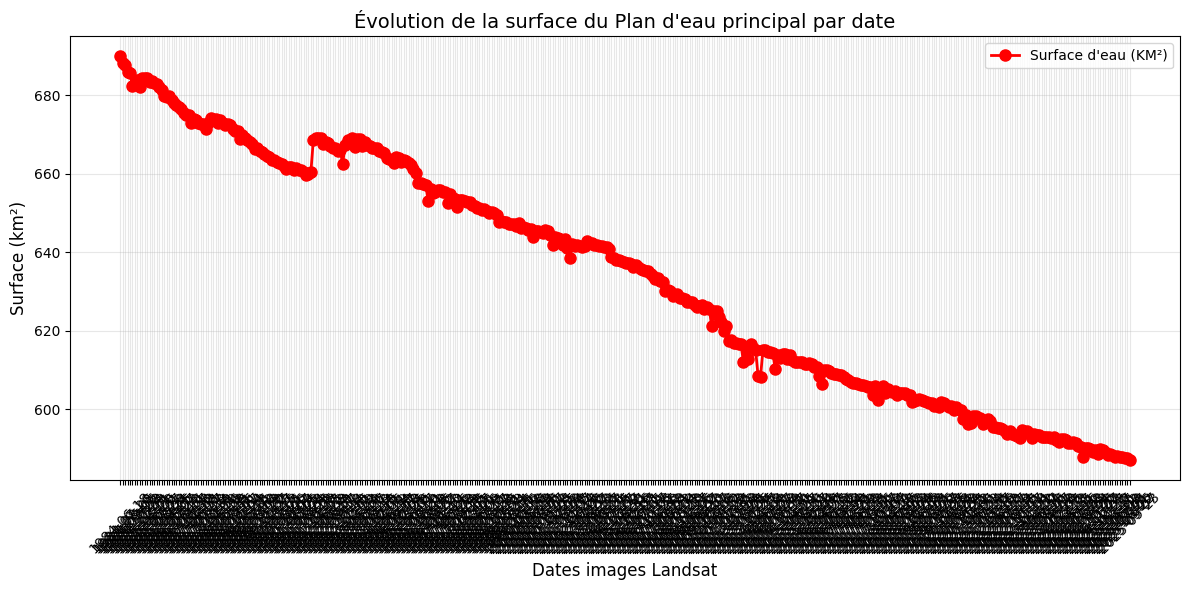


📊 STATISTIQUES DU PLAN D'EAU PRINCIPAL :
   - Surface moyenne : 634.05 km²
   - Surface max : 689.82 km²
   - Surface min : 587.21 km²


In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_largest_areas_evolution(largest_polygons):
    """
    Affiche l'évolution de la surface du plus grand plan d'eau par date
    """
    # Préparer les données
    dates = sorted(largest_polygons.keys())
    largest_areas = [largest_polygons[date]['largest_area'] for date in dates]

    # Créer un seul graphique
    plt.figure(figsize=(12, 6))
    plt.plot(dates, largest_areas, 'o-', linewidth=2, markersize=8,
             color='red', label="Surface d'eau (KM²)")

    plt.title("Évolution de la surface du Plan d'eau principal par date", fontsize=14)
    plt.ylabel('Surface (km²)', fontsize=12)
    plt.xlabel('Dates images Landsat', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    # ✅ Sauvegarde si le chemin est fourni
    try:
        plt.savefig('water_area.png', dpi=500, bbox_inches='tight')
        print(f"✅ Graphique enregistré")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde du graphique : {e}")
    plt.show()

    # Statistiques
    print("\n📊 STATISTIQUES DU PLAN D'EAU PRINCIPAL :")
    print(f"   - Surface moyenne : {np.mean(largest_areas):.2f} km²")
    print(f"   - Surface max : {np.max(largest_areas):.2f} km²")
    print(f"   - Surface min : {np.min(largest_areas):.2f} km²")

# Exemple d’appel :
plot_largest_areas_evolution(largest_polygons_clean)


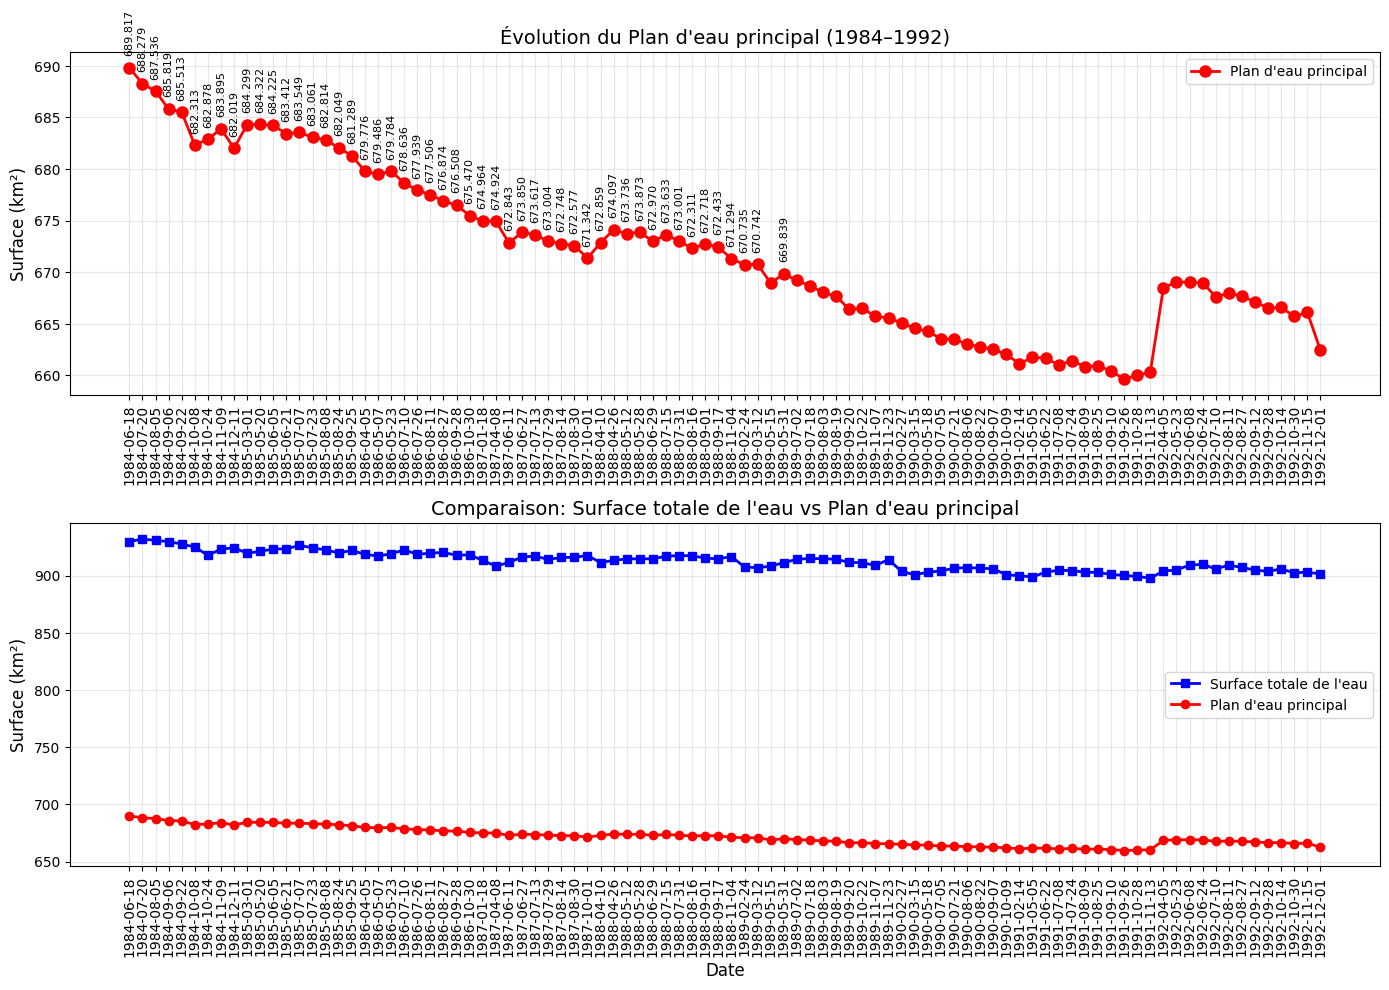


📊 STATISTIQUES 1984–1992 :
   - Surface moyenne : 671.88 km²
   - Surface max : 689.82 km²
   - Surface min : 659.62 km²
   - Contribution moyenne: 73.6% de la surface totale


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def plot_largest_areas_evolution(vectors_by_date, largest_polygons, top_n_labels=50,
                                 start_year=1984, end_year=1992):
    """
    Plot l'évolution de la surface du plus grand polygone par date,
    avec possibilité de filtrer une plage d'années.
    """
    # --- Filtrer les dates selon la période demandée ---
    all_dates = sorted(vectors_by_date.keys())
    filtered_dates = [
        d for d in all_dates
        if start_year <= datetime.strptime(d, "%Y-%m-%d").year <= end_year
    ]

    if not filtered_dates:
        print(f"Aucune date trouvée entre {start_year} et {end_year}.")
        return

    # --- Préparer les données filtrées ---
    largest_areas = np.array([largest_polygons[date]['largest_area'] for date in filtered_dates])
    total_areas = np.array([vectors_by_date[date]['total_area_km2'] for date in filtered_dates])

    # --- Créer les plots ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Plus grande surface par date
    ax1.plot(filtered_dates, largest_areas, 'o-', linewidth=2, markersize=8,
             color='red', label="Plan d'eau principal")
    ax1.set_title(f"Évolution du Plan d'eau principal ({start_year}–{end_year})", fontsize=14)
    ax1.set_ylabel('Surface (km²)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Annoter les top_n_labels plus grandes surfaces
    top_indices = largest_areas.argsort()[-top_n_labels:]
    for i in top_indices:
        ax1.annotate(f'{largest_areas[i]:.3f}', (filtered_dates[i], largest_areas[i]),
                     textcoords="offset points", xytext=(0,10),
                     ha='center', fontsize=8, rotation=90)

    # Plot 2: Comparaison avec la surface totale
    ax2.plot(filtered_dates, total_areas, 's-', linewidth=2, markersize=6,
             color='blue', label="Surface totale de l'eau")
    ax2.plot(filtered_dates, largest_areas, 'o-', linewidth=2, markersize=6,
             color='red', label="Plan d'eau principal")
    ax2.set_title("Comparaison: Surface totale de l'eau vs Plan d'eau principal", fontsize=14)
    ax2.set_ylabel('Surface (km²)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Rotation des dates sur l'axe x
    for ax in [ax1, ax2]:
        ax.tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    # --- Statistiques ---
    print(f"\n📊 STATISTIQUES {start_year}–{end_year} :")
    print(f"   - Surface moyenne : {np.mean(largest_areas):.2f} km²")
    print(f"   - Surface max : {np.max(largest_areas):.2f} km²")
    print(f"   - Surface min : {np.min(largest_areas):.2f} km²")
    print(f"   - Contribution moyenne: {(np.mean(largest_areas) / np.mean(total_areas) * 100):.1f}% de la surface totale")

# 🔹 Exemple d’appel :
plot_largest_areas_evolution(vectors_by_date_clean, largest_polygons_clean,
                             top_n_labels=50, start_year=1984, end_year=1992)


#### Afficher les dates qui ont des plus pétites surfaces d'eau parmis les principaux plans d'eau

In [16]:
# @title
def show_smallest_largest_polygons(largest_polygons, top_n=10):
    """
    Affiche les dates avec les plus petits 'plus grands polygones'
    """
    print(f"\n📉 TOP {top_n} DES DATES AVEC LES PLUS PETITS PLUS GRANDS POLYGONES")
    print("=" * 70)

    # Trier par surface croissante (plus petites d'abord)
    sorted_dates = sorted(largest_polygons.items(),
                         key=lambda x: x[1]['largest_area'])

    # Prendre les top_n plus petites
    smallest_dates = sorted_dates[:top_n]

    for i, (date_key, data) in enumerate(smallest_dates, 1):
        print(f"{i:2d}. {date_key} | "
              f"Surface: {data['largest_area']:.6f} km² | "
              f"({data['largest_area']*1000000:.1f} m²) | "
              f"Mois: {data['month']:02d}")

    return smallest_dates

# execution de la fonction
smallest_polygons = show_smallest_largest_polygons(largest_polygons_clean, top_n=10)


📉 TOP 10 DES DATES AVEC LES PLUS PETITS PLUS GRANDS POLYGONES
 1. 2025-09-23 | Surface: 587.209591 km² | (587209591.3 m²) | Mois: 09
 2. 2025-09-07 | Surface: 587.685803 km² | (587685802.7 m²) | Mois: 09
 3. 2025-08-22 | Surface: 587.723623 km² | (587723622.8 m²) | Mois: 08
 4. 2025-06-19 | Surface: 587.843389 km² | (587843389.2 m²) | Mois: 06
 5. 2025-08-06 | Surface: 587.882963 km² | (587882963.2 m²) | Mois: 08
 6. 2024-09-20 | Surface: 587.949550 km² | (587949550.3 m²) | Mois: 09
 7. 2025-07-21 | Surface: 587.993696 km² | (587993696.1 m²) | Mois: 07
 8. 2025-07-05 | Surface: 588.228655 km² | (588228655.3 m²) | Mois: 07
 9. 2025-06-03 | Surface: 588.317778 km² | (588317778.1 m²) | Mois: 06
10. 2025-03-31 | Surface: 588.400542 km² | (588400542.1 m²) | Mois: 03


#### Afficher les dates qui ont les plus grandes surfaces d'eau parmis les principaux plans d'eau

In [17]:
# @title
def show_largest_polygons_surfaces(largest_polygons, top_n=10):
    """
    Affiche les dates avec les plus grandes surfaces des plus grands polygones
    """
    print(f"\n📈 TOP {top_n} DES DATES AVEC LES PLUS GRANDES SURFACES")
    print("=" * 70)

    # Trier par surface décroissante (plus grandes d'abord)
    sorted_dates = sorted(largest_polygons.items(),
                         key=lambda x: x[1]['largest_area'],
                         reverse=True)

    # Prendre les top_n plus grandes
    largest_dates = sorted_dates[:top_n]

    for i, (date_key, data) in enumerate(largest_dates, 1):
        print(f"{i:2d}. {date_key} | "
              f"Surface: {data['largest_area']:.3f} km² | "
              f"({data['largest_area']*100:.1f} hectares) | "
              f"Mois: {data['month']:02d} | "
              f"Capteur: {'L5' if data['year'] <= 2012 else 'L8'}")

    return largest_dates

# Utilisation
largest_surfaces = show_largest_polygons_surfaces(largest_polygons, top_n=10)


📈 TOP 10 DES DATES AVEC LES PLUS GRANDES SURFACES
 1. 1984-06-18 | Surface: 689.817 km² | (68981.7 hectares) | Mois: 06 | Capteur: L5
 2. 1984-07-20 | Surface: 688.279 km² | (68827.9 hectares) | Mois: 07 | Capteur: L5
 3. 1984-08-05 | Surface: 687.536 km² | (68753.6 hectares) | Mois: 08 | Capteur: L5
 4. 1984-09-06 | Surface: 685.819 km² | (68581.9 hectares) | Mois: 09 | Capteur: L5
 5. 1984-09-22 | Surface: 685.513 km² | (68551.3 hectares) | Mois: 09 | Capteur: L5
 6. 1985-05-20 | Surface: 684.322 km² | (68432.2 hectares) | Mois: 05 | Capteur: L5
 7. 1985-03-01 | Surface: 684.299 km² | (68429.9 hectares) | Mois: 03 | Capteur: L5
 8. 1985-06-05 | Surface: 684.225 km² | (68422.5 hectares) | Mois: 06 | Capteur: L5
 9. 1984-11-09 | Surface: 683.895 km² | (68389.5 hectares) | Mois: 11 | Capteur: L5
10. 1985-07-07 | Surface: 683.549 km² | (68354.9 hectares) | Mois: 07 | Capteur: L5


## Traitement des données d'évapotranspiration (SPEI)

In [18]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

def load_spei_data_v2_10(roi, start_year=1984, end_year=2024, spei_timescale=12):
    """
    Charge les données SPEI Version 2.10 avec les bonnes bandes
    """
    try:
        # Collection SPEI Global - Version 2.10 (comme dans la doc)
        spei_collection = ee.ImageCollection("CSIC/SPEI/2_10")

        # Filtrer par période
        spei_filtered = spei_collection.filterDate(f'{start_year}-01-01', f'{end_year}-12-31')

        # Sélectionner la bande SPEI correspondante
        spei_band = f'SPEI_{spei_timescale:02d}_month'
        spei_selected = spei_filtered.select(spei_band)

        count = spei_selected.size().getInfo()
        print(f"📊 Chargement {spei_band}: {count} images")

        if count == 0:
            print(f"⚠️  Aucune image {spei_band} trouvée pour {start_year}-{end_year}")
            return pd.DataFrame()

        # Extraire les données temporelles
        def extract_spei_data(image):
            date = image.date()
            mean_spei = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=55660,  # Taille de pixel = 55660 mètres selon la doc
                bestEffort=True,
                maxPixels=1e9
            ).get(spei_band)

            return ee.Feature(None, {
                'date': date.format('YYYY-MM-dd'),
                'year': date.get('year'),
                'month': date.get('month'),
                'spei': mean_spei,
                'spei_band': spei_band,
                'system:time_start': date.millis()
            })

        # Convertir en liste et DataFrame
        spei_features = spei_selected.map(extract_spei_data)
        spei_list = spei_features.getInfo()['features']

        if not spei_list:
            print(f"❌ Aucune donnée {spei_band} extraite")
            return pd.DataFrame()

        spei_data = []
        for feature in spei_list:
            props = feature['properties']
            # Vérifier que les données sont valides
            if props.get('spei') is not None:
                spei_data.append({
                    'date': props['date'],
                    'year': props['year'],
                    'month': props['month'],
                    'spei': props['spei'],
                    'spei_band': props['spei_band'],
                    'timestamp': props['system:time_start']
                })

        if not spei_data:
            print(f"❌ Aucune donnée {spei_band} valide")
            return pd.DataFrame()

        df_spei = pd.DataFrame(spei_data)
        df_spei['date'] = pd.to_datetime(df_spei['date'])
        df_spei = df_spei.sort_values('date').reset_index(drop=True)

        print(f"✅ {spei_band}: {len(df_spei)} points de données chargés")
        print(f"   Période: {df_spei['date'].min().strftime('%Y-%m')} à {df_spei['date'].max().strftime('%Y-%m')}")
        print(f"   Plage SPEI: [{df_spei['spei'].min():.2f}, {df_spei['spei'].max():.2f}]")

        return df_spei

    except Exception as e:
        print(f"❌ Erreur lors du chargement {spei_band}: {str(e)}")
        return pd.DataFrame()

# Test de la collection SPEI
def test_spei_collection():
    """
    Teste la collection SPEI 2.10
    """
    try:
        spei_collection = ee.ImageCollection("CSIC/SPEI/2_10")
        print("✅ Collection SPEI/2_10 trouvée")

        # Vérifier les bandes disponibles
        first_image = spei_collection.first()
        band_names = first_image.getInfo()['bands']
        print("📊 Bandes disponibles:")
        for band in band_names:
            print(f"   - {band['id']}")

        return True
    except Exception as e:
        print(f"❌ Collection SPEI/2_10 non accessible: {e}")
        return False

# Charger les données SPEI pour différentes échelles temporelles
print("🌍 CHARGEMENT DES DONNÉES SPEI Version 2.10...")

# Tester d'abord la collection
if test_spei_collection():
    # Échelles SPEI à charger (1 à 48 mois selon la doc)
    spei_scales = [1, 3, 6, 12, 24, 36, 48]  # Vous pouvez ajouter d'autres échelles
    spei_datasets = {}

    for scale in spei_scales:
        print(f"\n📥 Chargement SPEI-{scale:02d}...")
        df_spei = load_spei_data_v2_10(roi, 1984, 2024, scale)
        if not df_spei.empty:
            spei_datasets[scale] = df_spei
        else:
            print(f"   ❌ Échec du chargement SPEI-{scale:02d}")

    # Vérifier quelles échelles ont été chargées avec succès
    successful_scales = [scale for scale, df in spei_datasets.items() if not df.empty]
    print(f"\n✅ Échelles SPEI chargées avec succès: {successful_scales}")
else:
    print("❌ Impossible d'accéder à la collection SPEI")
    spei_datasets = {}

🌍 CHARGEMENT DES DONNÉES SPEI Version 2.10...
✅ Collection SPEI/2_10 trouvée
📊 Bandes disponibles:
   - SPEI_01_month
   - SPEI_02_month
   - SPEI_03_month
   - SPEI_04_month
   - SPEI_05_month
   - SPEI_06_month
   - SPEI_07_month
   - SPEI_08_month
   - SPEI_09_month
   - SPEI_10_month
   - SPEI_11_month
   - SPEI_12_month
   - SPEI_13_month
   - SPEI_14_month
   - SPEI_15_month
   - SPEI_16_month
   - SPEI_17_month
   - SPEI_18_month
   - SPEI_19_month
   - SPEI_20_month
   - SPEI_21_month
   - SPEI_22_month
   - SPEI_23_month
   - SPEI_24_month
   - SPEI_25_month
   - SPEI_26_month
   - SPEI_27_month
   - SPEI_28_month
   - SPEI_29_month
   - SPEI_30_month
   - SPEI_31_month
   - SPEI_32_month
   - SPEI_33_month
   - SPEI_34_month
   - SPEI_35_month
   - SPEI_36_month
   - SPEI_37_month
   - SPEI_38_month
   - SPEI_39_month
   - SPEI_40_month
   - SPEI_41_month
   - SPEI_42_month
   - SPEI_43_month
   - SPEI_44_month
   - SPEI_45_month
   - SPEI_46_month
   - SPEI_47_month
   - SPE

In [19]:
# Vérifier la structure d'un élément
print(f"\n🔍 Structure d'un élément:")
first_key = list(spei_datasets.keys())[0]
first_value = spei_datasets[first_key]
print(f"Clé: '{first_key}'")
print(f"Type de la valeur: {type(first_value)}")
print(f"Clés dans la valeur: {list(first_value.keys())}")


🔍 Structure d'un élément:
Clé: '1'
Type de la valeur: <class 'pandas.core.frame.DataFrame'>
Clés dans la valeur: ['date', 'year', 'month', 'spei', 'spei_band', 'timestamp']


In [20]:
## voir entete du df du spei 48
import pprint
pprint.pprint(spei_datasets[48])

          date  year  month      spei      spei_band      timestamp
0   1984-01-01  1984      1  1.187935  SPEI_48_month   441763200000
1   1984-02-01  1984      2  0.841386  SPEI_48_month   444441600000
2   1984-03-01  1984      3  0.863410  SPEI_48_month   446947200000
3   1984-04-01  1984      4  0.922850  SPEI_48_month   449625600000
4   1984-05-01  1984      5  0.900305  SPEI_48_month   452217600000
..         ...   ...    ...       ...            ...            ...
475 2023-08-01  2023      8 -0.049221  SPEI_48_month  1690848000000
476 2023-09-01  2023      9 -0.081364  SPEI_48_month  1693526400000
477 2023-10-01  2023     10 -0.096253  SPEI_48_month  1696118400000
478 2023-11-01  2023     11  0.062638  SPEI_48_month  1698796800000
479 2023-12-01  2023     12  0.041828  SPEI_48_month  1701388800000

[480 rows x 6 columns]


### Préparation des données Landsat pour corrélation

In [21]:
def prepare_landsat_for_correlation(largest_polygons):
    """
    Prépare les données Landsat pour l'analyse de corrélation
    """
    # Convertir en DataFrame
    landsat_data = []
    for date_key, data in largest_polygons.items():
        landsat_data.append({
            'date': pd.to_datetime(data['date']),
            'year': data['year'],
            'month': data['month'],
            'water_area_km2': data['largest_area'],
            'total_water_area': data['total_area_date'],
            'sensor': 'L5' if data['year'] <= 2012 else 'L8'
        })

    df_landsat = pd.DataFrame(landsat_data)
    df_landsat = df_landsat.sort_values('date').reset_index(drop=True)

    # Agrégation mensuelle
    df_monthly = df_landsat.groupby(['year', 'month']).agg({
        'water_area_km2': 'mean',
        'total_water_area': 'mean',
        'date': 'first'
    }).reset_index()

    df_monthly['date'] = pd.to_datetime(df_monthly['date'])

    # Agrégation annuelle
    df_annual = df_landsat.groupby(['year']).agg({
        'water_area_km2': 'mean',
        'total_water_area': 'mean',
        'date': 'first'
    }).reset_index()
    df_annual['date'] = pd.to_datetime(df_annual['date'])

    print(f"📊 Données Landsat préparées: {len(df_landsat)} points journaliers, {len(df_monthly)} points mensuels, {len(df_annual)} points annuels")

    return df_landsat, df_monthly, df_annual

# Préparer les données Landsat
print("\n🛰️ PRÉPARATION DES DONNÉES LANDSAT...")
df_landsat_daily, df_landsat_monthly, df_landsat_annual = prepare_landsat_for_correlation(largest_polygons_clean)


🛰️ PRÉPARATION DES DONNÉES LANDSAT...
📊 Données Landsat préparées: 414 points journaliers, 290 points mensuels, 41 points annuels


In [22]:
## voir entete du df de la surface d'eau moyennee par mois
import pprint
pprint.pprint(df_landsat_monthly.head())

   year  month  water_area_km2  total_water_area       date
0  1984      6      689.817459        929.666201 1984-06-18
1  1984      7      688.278939        931.963985 1984-07-20
2  1984      8      687.536179        930.801700 1984-08-05
3  1984      9      685.665914        928.628498 1984-09-06
4  1984     10      682.595691        921.355075 1984-10-08


In [23]:
## voir entete du df de la surface d'eau moyennee par an
import pprint
pprint.pprint(df_landsat_annual.head())

   year  water_area_km2  total_water_area       date
0  1984      685.341102        926.648295 1984-06-18
1  1985      683.224514        922.465381 1985-03-01
2  1986      677.997789        919.060090 1986-04-05
3  1987      673.318908        914.409816 1987-01-18
4  1988      672.993188        915.155057 1988-04-10


### Tracer l’évolution mensuelle Surface d’eau vs SPEI

✅ Fusion réussie : 271 points temporels communs
✅ Graphique enregistré


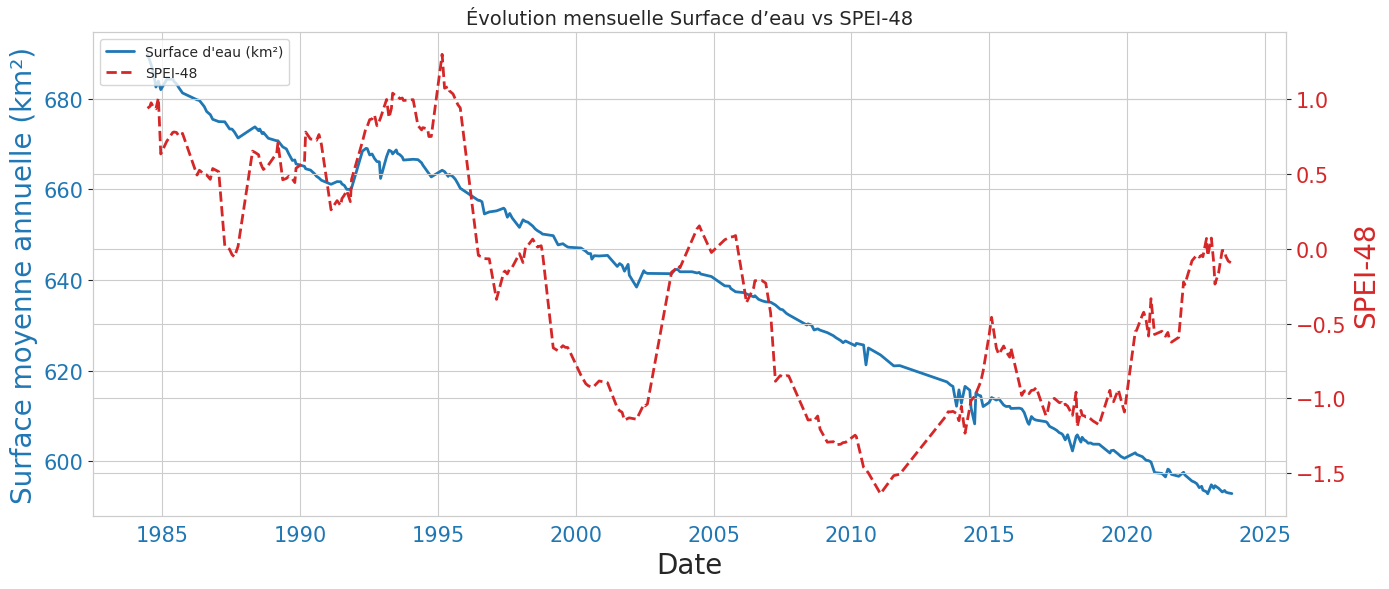

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_water_spei_timeseries(df_landsat_monthly, df_spei, spei_scale):
    """
    Trace l'évolution mensuelle de la surface d'eau moyenne et du SPEI
    sur deux axes Y.
    """
    if df_spei.empty or df_landsat_monthly.empty:
        print("❌ Données insuffisantes pour la visualisation")
        return

    # 1️⃣ Préparer les colonnes communes
    df_landsat = df_landsat_monthly.copy()
    df_spei = df_spei.copy()
    df_landsat['year_month'] = df_landsat['date'].dt.to_period('M')
    df_spei['year_month'] = df_spei['date'].dt.to_period('M')

    # 2️⃣ Fusion temporelle
    df_merged = pd.merge(df_landsat, df_spei, on='year_month', suffixes=('_landsat', '_spei'))
    df_merged['date'] = df_merged['date_landsat']  # pour affichage
    df_merged = df_merged.sort_values('date')

    print(f"✅ Fusion réussie : {len(df_merged)} points temporels communs")

    # 3️⃣ Tracé avec double axe Y
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Axe 1 — Surface d’eau
    color1 = "tab:blue"
    ax1.set_xlabel("Date", fontsize=20)
    ax1.set_ylabel("Surface moyenne annuelle (km²)", color=color1, fontsize=20)
    ax1.plot(df_merged['date'], df_merged['water_area_km2'],
             color=color1, linewidth=2, label="Surface d'eau (km²)")
    ax1.tick_params(axis='both', labelsize=15, labelcolor=color1)

    # Axe 2 — SPEI
    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel(f"SPEI-{spei_scale}", color=color2, fontsize=20)
    ax2.plot(df_merged['date'], df_merged['spei'],
             color=color2, linestyle='--', linewidth=2, label=f"SPEI-{spei_scale}")
    ax2.tick_params(axis='both', labelsize=15, labelcolor=color2)

    # 4️⃣ Titres et légendes
    plt.title(f"Évolution mensuelle Surface d’eau vs SPEI-{spei_scale}", fontsize=14)
    fig.tight_layout()

    # Ajouter une légende combinée
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    # ✅ Sauvegarde si le chemin est fourni
    try:
        plt.savefig('waterVSspei.png', dpi=500, bbox_inches='tight')
        print(f"✅ Graphique enregistré")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde du graphique : {e}")
    plt.show()
    plt.show()

    return df_merged

# Exemple avec le SPEI à 12 mois  df_landsat_monthly
spei_scale = 48
df_spei = spei_datasets[spei_scale]
df_merged_spei12 = plot_water_spei_timeseries(df_landsat_monthly, df_spei, spei_scale)


### Tracer l’évolution annuelle Surface d’eau vs SPEI

✅ Fusion réussie : 39 années communes
✅ Graphique enregistré : waterVSspei_annual.png


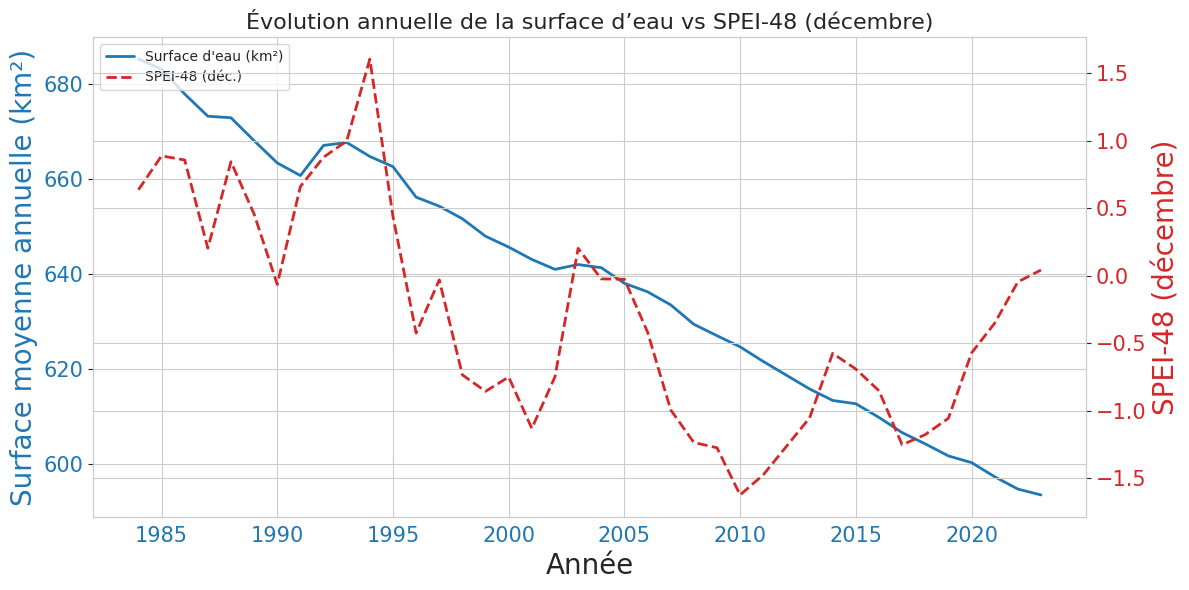

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_water_spei_timeseries_annual(df_landsat_annual, df_spei, spei_scale):
    """
    Trace l'évolution annuelle de la surface d'eau moyenne et du SPEI12 (valeur de décembre)
    sur deux axes Y.
    """
    if df_spei.empty or df_landsat_annual.empty:
        print("❌ Données insuffisantes pour la visualisation")
        return

    # 1️⃣ Préparer les données
    df_landsat = df_landsat_annual.copy()
    df_spei = df_spei.copy()

    # Extraire uniquement le SPEI de décembre pour chaque année
    df_spei['year'] = df_spei['date'].dt.year
    df_spei['month'] = df_spei['date'].dt.month
    df_spei_dec = df_spei[df_spei['month'] == 12].copy()

    # 2️⃣ Fusion annuelle sur l’année
    df_merged = pd.merge(df_landsat, df_spei_dec[['year', 'spei']], on='year', how='inner')
    df_merged = df_merged.sort_values('year')

    print(f"✅ Fusion réussie : {len(df_merged)} années communes")

    # 3️⃣ Tracé avec double axe Y
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color1 = "tab:blue"
    ax1.set_xlabel("Année", fontsize=20)
    ax1.set_ylabel("Surface moyenne annuelle (km²)", color=color1, fontsize=20)
    ax1.plot(df_merged['year'], df_merged['water_area_km2'],
             color=color1, linewidth=2, label="Surface d'eau (km²)")
    ax1.tick_params(axis='both', labelsize=15, labelcolor=color1)

    # Axe 2 — SPEI décembre
    ax2 = ax1.twinx()
    color2 = "tab:red"
    ax2.set_ylabel(f"SPEI-{spei_scale} (décembre)", color=color2, fontsize=20)
    ax2.plot(df_merged['year'], df_merged['spei'],
             color=color2, linestyle='--', linewidth=2, label=f"SPEI-{spei_scale} (déc.)")
    ax2.tick_params(axis='both', labelsize=15, labelcolor=color2)

    # 4️⃣ Titres et légendes
    plt.title(f"Évolution annuelle de la surface d’eau vs SPEI-{spei_scale} (décembre)", fontsize=16)
    fig.tight_layout()

    # Légende combinée
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    # Sauvegarde
    try:
        plt.savefig('waterVSspei_annual.png', dpi=500, bbox_inches='tight')
        print("✅ Graphique enregistré : waterVSspei_annual.png")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde : {e}")

    plt.show()
    return df_merged

## execution
spei_scale = 48  # ou 48 selon ton cas
df_spei = spei_datasets[spei_scale]
df_merged_spei12 = plot_water_spei_timeseries_annual(df_landsat_annual, df_spei, spei_scale)

### Analyse de corrélation SPEI vs Surfaces d'eau

In [27]:
def analyze_spei_water_correlation(spei_data, landsat_data, spei_scale):
    """
    Analyse la corrélation entre SPEI et surfaces d'eau
    """
    if spei_data.empty or landsat_data.empty:
        print(f"❌ Données insuffisantes pour SPEI-{spei_scale}")
        return None

    # Fusionner les données sur la base année-mois
    spei_data['year_month'] = spei_data['date'].dt.to_period('M')
    landsat_data['year_month'] = landsat_data['date'].dt.to_period('M')

    merged_df = pd.merge(landsat_data, spei_data, on='year_month', suffixes=('_landsat', '_spei'))

    if merged_df.empty:
        print(f"❌ Aucune correspondance temporelle pour SPEI-{spei_scale}")
        return None

    # Nettoyer les colonnes
    merged_df = merged_df[['date_landsat', 'year_landsat', 'month_landsat',
                          'water_area_km2', 'total_water_area', 'spei', 'spei_band']]
    merged_df.columns = ['date', 'year', 'month', 'water_area_km2', 'total_water_area', 'spei', 'spei_band']

    print(f"✅ SPEI-{spei_scale}: {len(merged_df)} points de correspondance")

    # Analyse de corrélation
    corr_pearson = stats.pearsonr(merged_df['spei'], merged_df['water_area_km2'])
    corr_spearman = stats.spearmanr(merged_df['spei'], merged_df['water_area_km2'])

    print(f"   Pearson: r = {corr_pearson[0]:.3f}, p-value = {corr_pearson[1]:.4f}")
    print(f"   Spearman: ρ = {corr_spearman[0]:.3f}, p-value = {corr_spearman[1]:.4f}")

    # Régression linéaire
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        merged_df['spei'], merged_df['water_area_km2']
    )

    return {
        'data': merged_df,
        'pearson_r': corr_pearson[0],
        'pearson_p': corr_pearson[1],
        'spearman_rho': corr_spearman[0],
        'spearman_p': corr_spearman[1],
        'r_squared': r_value**2,
        'regression_p': p_value,
        'slope': slope,
        'intercept': intercept,
        'n_points': len(merged_df)
    }

# Exécuter l'analyse pour toutes les échelles SPEI disponibles
correlation_results = {}

if spei_datasets:
    for scale in spei_datasets.keys():
        print(f"\n{'='*60}")
        print(f"ANALYSE CORRÉLATION SPEI-{scale:02d}")
        print(f"{'='*60}")

        results_corr = analyze_spei_water_correlation(spei_datasets[scale], df_landsat_monthly, scale)
        if results_corr:
            correlation_results[scale] = results_corr


ANALYSE CORRÉLATION SPEI-01
✅ SPEI-1: 271 points de correspondance
   Pearson: r = 0.230, p-value = 0.0001
   Spearman: ρ = 0.212, p-value = 0.0005

ANALYSE CORRÉLATION SPEI-03
✅ SPEI-3: 271 points de correspondance
   Pearson: r = 0.311, p-value = 0.0000
   Spearman: ρ = 0.308, p-value = 0.0000

ANALYSE CORRÉLATION SPEI-06
✅ SPEI-6: 271 points de correspondance
   Pearson: r = 0.340, p-value = 0.0000
   Spearman: ρ = 0.324, p-value = 0.0000

ANALYSE CORRÉLATION SPEI-12
✅ SPEI-12: 271 points de correspondance
   Pearson: r = 0.327, p-value = 0.0000
   Spearman: ρ = 0.297, p-value = 0.0000

ANALYSE CORRÉLATION SPEI-24
✅ SPEI-24: 271 points de correspondance
   Pearson: r = 0.513, p-value = 0.0000
   Spearman: ρ = 0.497, p-value = 0.0000

ANALYSE CORRÉLATION SPEI-36
✅ SPEI-36: 271 points de correspondance
   Pearson: r = 0.634, p-value = 0.0000
   Spearman: ρ = 0.616, p-value = 0.0000

ANALYSE CORRÉLATION SPEI-48
✅ SPEI-48: 271 points de correspondance
   Pearson: r = 0.717, p-value = 0

### Scatter plot surface d'eau mensuelle VS SPEI

✅ Fusion réussie : 271 points temporels communs
📈 Coefficient de corrélation de Pearson : r = 0.717 (p = 0.0000)
✅ Graphique enregistré : scatter_water_spei_48_colorbar.png


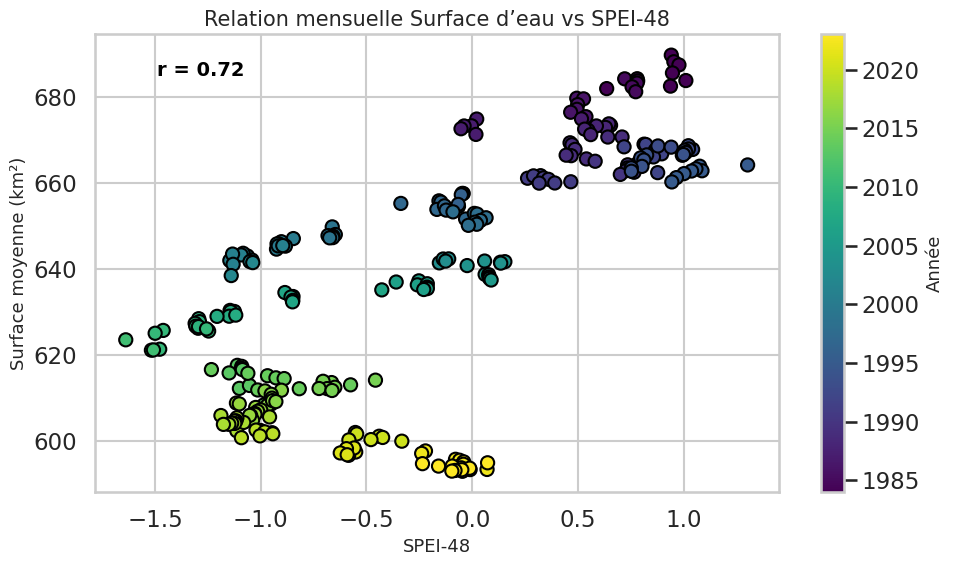

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

def plot_water_spei_scatter(df_landsat_monthly, df_spei, spei_scale):
    """
    Crée un scatter plot entre la surface d'eau moyenne mensuelle et le SPEI,
    avec coloration continue (viridis) selon l'année et affichage du coefficient r.
    """

    if df_spei.empty or df_landsat_monthly.empty:
        print("❌ Données insuffisantes pour la visualisation")
        return

    # 🔹 Préparation des périodes communes
    df_landsat = df_landsat_monthly.copy()
    df_spei = df_spei.copy()
    df_landsat['year_month'] = df_landsat['date'].dt.to_period('M')
    df_spei['year_month'] = df_spei['date'].dt.to_period('M')

    # 🔹 Fusion temporelle
    df_merged = pd.merge(df_landsat, df_spei, on='year_month', suffixes=('_landsat', '_spei'))
    df_merged['date'] = df_merged['date_landsat']
    df_merged = df_merged.sort_values('date')
    df_merged['year'] = df_merged['date'].dt.year

    print(f"✅ Fusion réussie : {len(df_merged)} points temporels communs")

    # 🔹 Calcul du coefficient de corrélation de Pearson
    r, p = pearsonr(df_merged['spei'], df_merged['water_area_km2'])
    print(f"📈 Coefficient de corrélation de Pearson : r = {r:.3f} (p = {p:.4f})")

    # 🔹 Création du scatter plot avec colorbar
    sns.set_style("whitegrid")
    sns.set_context("talk")

    plt.figure(figsize=(10, 6))

    scatter = plt.scatter(
        df_merged['spei'],
        df_merged['water_area_km2'],
        c=df_merged['year'],
        cmap='viridis',
        s=90,
        edgecolors='black'
    )

    # 🔹 Ajout de la colorbar (année)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Année", fontsize=13)

    # 🔹 Ajout du coefficient r sur le graphique
    plt.text(
        x=df_merged['spei'].min() + 0.05 * (df_merged['spei'].max() - df_merged['spei'].min()),
        y=df_merged['water_area_km2'].max() - 0.05 * (df_merged['water_area_km2'].max() - df_merged['water_area_km2'].min()),
        s=f"r = {r:.2f}",
        fontsize=14,
        color="black",
        fontweight="bold"
    )

    # 🔹 Titres et labels
    plt.title(f"Relation mensuelle Surface d’eau vs SPEI-{spei_scale}", fontsize=15)
    plt.xlabel(f"SPEI-{spei_scale}", fontsize=13)
    plt.ylabel("Surface moyenne (km²)", fontsize=13)

    plt.tight_layout()

    # 🔹 Sauvegarde
    try:
        filename = f"scatter_water_spei_{spei_scale}_colorbar.png"
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        print(f"✅ Graphique enregistré : {filename}")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde : {e}")

    plt.show()

    return df_merged, r, p

spei_scale = 48  # ou 12, 24, 36 selon ton cas
df_spei = spei_datasets[spei_scale]

df_scatter_monthly, r, p = plot_water_spei_scatter(df_landsat_monthly, df_spei, spei_scale)


### Visualisations complètes


📊 CRÉATION DES VISUALISATIONS...


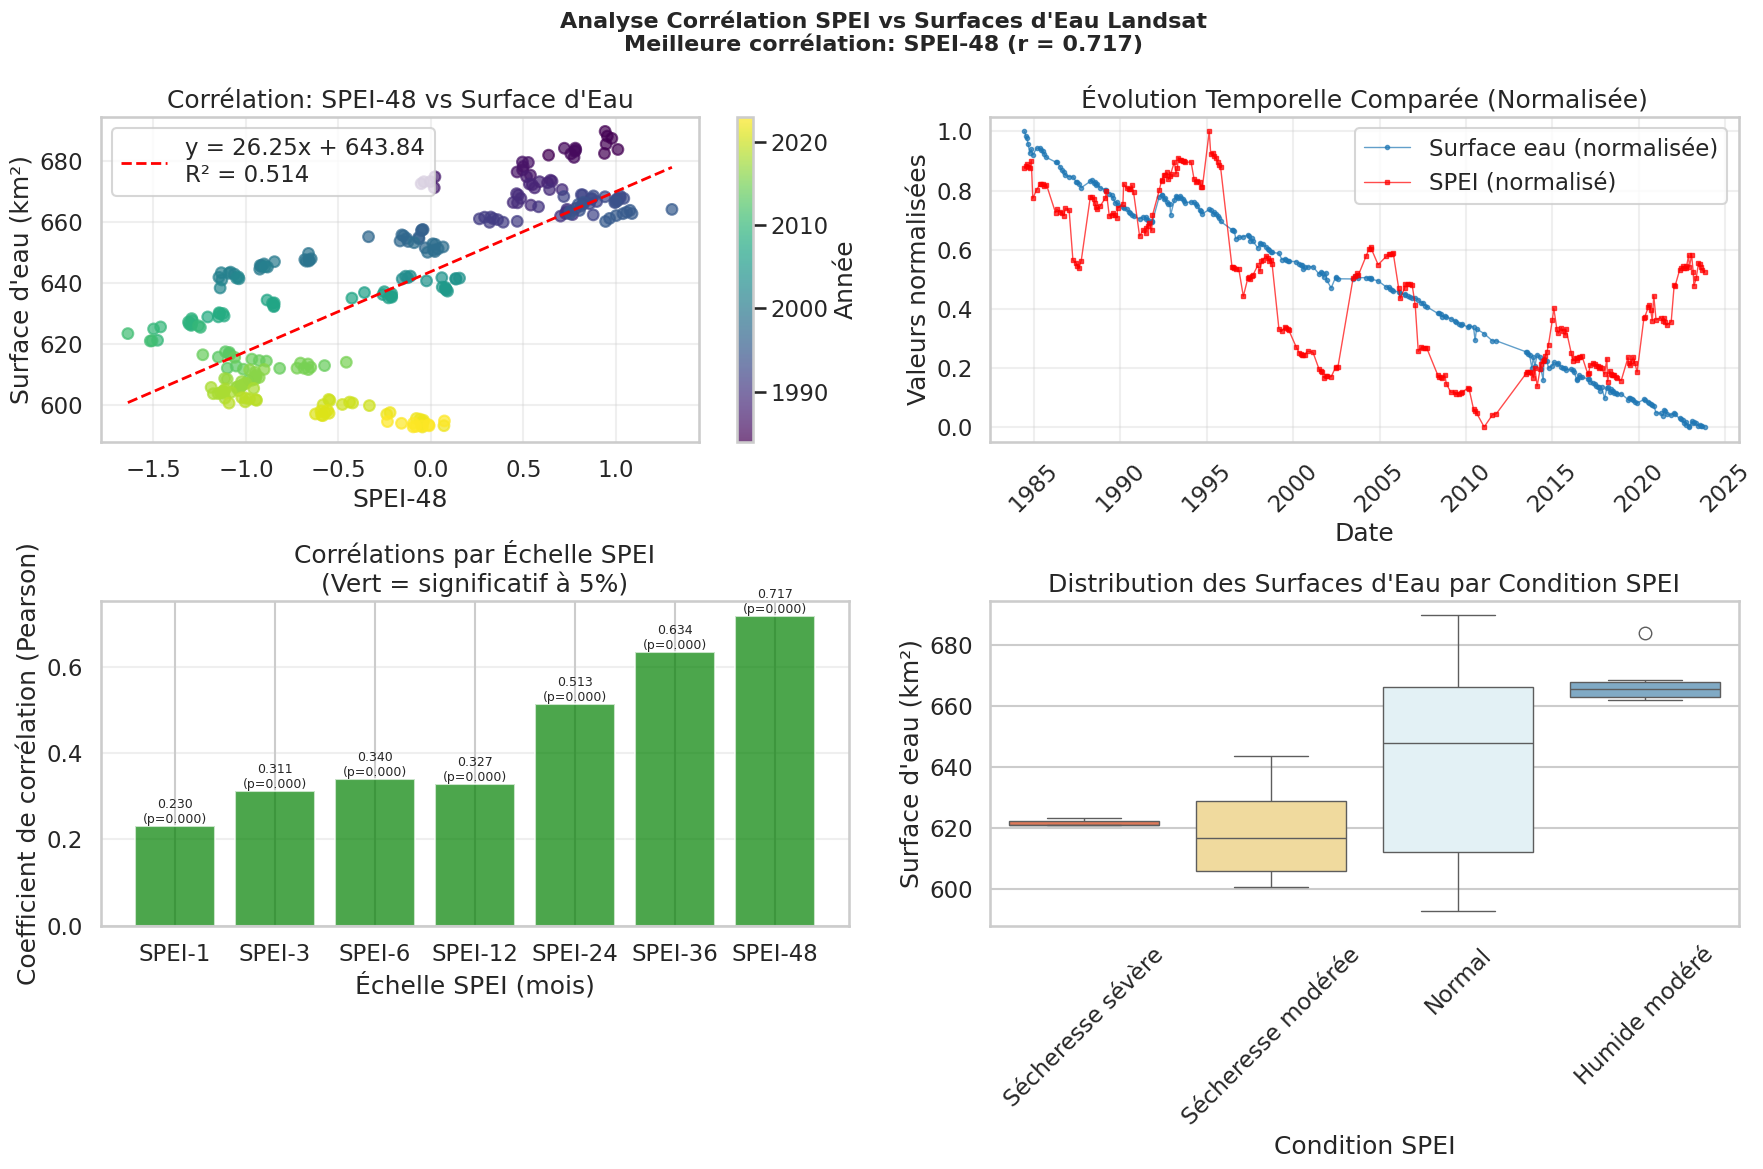

In [30]:
def create_spei_visualizations(correlation_results):
    """
    Crée des visualisations complètes pour l'analyse SPEI
    """
    if not correlation_results:
        print("❌ Aucune donnée à visualiser")
        return

    # Trouver l'échelle avec la meilleure corrélation
    best_scale = max(correlation_results.keys(),
                    key=lambda x: abs(correlation_results[x]['pearson_r']))
    best_data = correlation_results[best_scale]['data']
    best_stats = correlation_results[best_scale]

    # Créer les visualisations
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'Analyse Corrélation SPEI vs Surfaces d\'Eau Landsat\n'
                f'Meilleure corrélation: SPEI-{best_scale} (r = {best_stats["pearson_r"]:.3f})',
                fontsize=16, fontweight='bold')

    # 1. Graphique de dispersion
    ax1 = axes[0, 0]
    scatter = ax1.scatter(best_data['spei'], best_data['water_area_km2'],
                         c=best_data['year'], cmap='viridis', alpha=0.7, s=60)
    plt.colorbar(scatter, ax=ax1, label='Année')

    # Ligne de régression
    x_range = np.linspace(best_data['spei'].min(), best_data['spei'].max(), 100)
    y_range = best_stats['slope'] * x_range + best_stats['intercept']
    ax1.plot(x_range, y_range, 'r--', linewidth=2,
             label=f'y = {best_stats["slope"]:.2f}x + {best_stats["intercept"]:.2f}\nR² = {best_stats["r_squared"]:.3f}')

    ax1.set_xlabel(f'SPEI-{best_scale}')
    ax1.set_ylabel('Surface d\'eau (km²)')
    ax1.set_title(f'Corrélation: SPEI-{best_scale} vs Surface d\'Eau')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Tendance temporelle comparée
    ax2 = axes[0, 1]
    # Normaliser les données pour superposition
    water_norm = (best_data['water_area_km2'] - best_data['water_area_km2'].min()) / \
                 (best_data['water_area_km2'].max() - best_data['water_area_km2'].min())
    spei_norm = (best_data['spei'] - best_data['spei'].min()) / \
                (best_data['spei'].max() - best_data['spei'].min())

    ax2.plot(best_data['date'], water_norm, 'o-', label='Surface eau (normalisée)',
             alpha=0.7, linewidth=1, markersize=3)
    ax2.plot(best_data['date'], spei_norm, 's-', label='SPEI (normalisé)',
             alpha=0.7, linewidth=1, markersize=3, color='red')

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Valeurs normalisées')
    ax2.set_title('Évolution Temporelle Comparée (Normalisée)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # 3. Comparaison des corrélations par échelle
    ax3 = axes[1, 0]
    scales = list(correlation_results.keys())
    correlations = [correlation_results[s]['pearson_r'] for s in scales]
    p_values = [correlation_results[s]['pearson_p'] for s in scales]

    colors = ['green' if p < 0.05 else 'gray' for p in p_values]
    bars = ax3.bar(range(len(scales)), correlations, color=colors, alpha=0.7)

    ax3.set_xlabel('Échelle SPEI (mois)')
    ax3.set_ylabel('Coefficient de corrélation (Pearson)')
    ax3.set_title('Corrélations par Échelle SPEI\n(Vert = significatif à 5%)')
    ax3.set_xticks(range(len(scales)))
    ax3.set_xticklabels([f'SPEI-{s}' for s in scales])
    ax3.axhline(y=0, color='black', linewidth=0.8)
    ax3.grid(True, alpha=0.3, axis='y')

    # Ajouter les valeurs sur les barres
    for i, (bar, corr, p_val) in enumerate(zip(bars, correlations, p_values)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{corr:.3f}\n(p={p_val:.3f})',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

    # 4. Distribution des conditions SPEI vs surfaces d'eau
    ax4 = axes[1, 1]

    # Catégoriser les conditions SPEI
    def categorize_spei(spei_val):
        if spei_val < -2:
            return 'Sécheresse extrême'
        elif spei_val < -1.5:
            return 'Sécheresse sévère'
        elif spei_val < -1:
            return 'Sécheresse modérée'
        elif spei_val < 1:
            return 'Normal'
        elif spei_val < 1.5:
            return 'Humide modéré'
        elif spei_val < 2:
            return 'Humide sévère'
        else:
            return 'Humide extrême'

    best_data['spei_category'] = best_data['spei'].apply(categorize_spei)

    # Boxplot
    categories_order = ['Sécheresse extrême', 'Sécheresse sévère', 'Sécheresse modérée',
                       'Normal', 'Humide modéré', 'Humide sévère', 'Humide extrême']
    available_categories = [cat for cat in categories_order if cat in best_data['spei_category'].unique()]

    if available_categories:
        sns.boxplot(data=best_data, x='spei_category', y='water_area_km2',
                   order=available_categories, ax=ax4, palette='RdYlBu')
        ax4.set_xlabel('Condition SPEI')
        ax4.set_ylabel('Surface d\'eau (km²)')
        ax4.set_title('Distribution des Surfaces d\'Eau par Condition SPEI')
        ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return fig

# Créer les visualisations
if correlation_results:
    print("\n📊 CRÉATION DES VISUALISATIONS...")
    fig = create_spei_visualizations(correlation_results)

### Analyse de la correlation de la surface d'eau moyeenne par Année et les SPEI 12, 24, 36 et 48

In [31]:
from scipy import stats

def extract_spei_december(spei_df):
    """
    Extrait le SPEI au 1er décembre de chaque année.
    """
    spei_df = spei_df.copy()
    spei_df['month'] = spei_df['date'].dt.month
    return spei_df[spei_df['month'] == 12][['year', 'spei', 'date']]

# Échelles SPEI à tester
spei_scales = [12, 24, 36, 48]

# Dictionnaire pour stocker les résultats
correlation_summary = {}

for scale in spei_scales:
    print(f"\n📊 Analyse pour SPEI-{scale}...")

    # Vérification si l'échelle est bien disponible
    if scale not in spei_datasets or spei_datasets[scale].empty:
        print(f"❌ SPEI-{scale} non disponible.")
        continue

    # Extraire le SPEI de décembre
    spei_december = extract_spei_december(spei_datasets[scale])

    # Fusionner avec les moyennes annuelles de surface d'eau
    merged_annual = pd.merge(df_landsat_annual, spei_december, on='year', suffixes=('', '_spei'))

    if merged_annual.empty:
        print(f"⚠️ Pas de données fusionnées pour SPEI-{scale}")
        continue

    # Calcul des corrélations
    corr_pearson = stats.pearsonr(merged_annual['spei'], merged_annual['water_area_km2'])
    corr_spearman = stats.spearmanr(merged_annual['spei'], merged_annual['water_area_km2'])

    # Affichage
    print(f"✅ Corrélation annuelle (SPEI-{scale} décembre) vs Surface d’eau :")
    print(f"   ➤ Pearson r = {corr_pearson[0]:.3f} (p = {corr_pearson[1]:.4f})")
    print(f"   ➤ Spearman ρ = {corr_spearman[0]:.3f} (p = {corr_spearman[1]:.4f})")

    # Stocker les résultats
    correlation_summary[scale] = {
        'pearson_r': corr_pearson[0],
        'pearson_p': corr_pearson[1],
        'spearman_rho': corr_spearman[0],
        'spearman_p': corr_spearman[1],
        'n': len(merged_annual)
    }



📊 Analyse pour SPEI-12...
✅ Corrélation annuelle (SPEI-12 décembre) vs Surface d’eau :
   ➤ Pearson r = 0.292 (p = 0.0716)
   ➤ Spearman ρ = 0.266 (p = 0.1014)

📊 Analyse pour SPEI-24...
✅ Corrélation annuelle (SPEI-24 décembre) vs Surface d’eau :
   ➤ Pearson r = 0.476 (p = 0.0022)
   ➤ Spearman ρ = 0.500 (p = 0.0012)

📊 Analyse pour SPEI-36...
✅ Corrélation annuelle (SPEI-36 décembre) vs Surface d’eau :
   ➤ Pearson r = 0.605 (p = 0.0000)
   ➤ Spearman ρ = 0.611 (p = 0.0000)

📊 Analyse pour SPEI-48...
✅ Corrélation annuelle (SPEI-48 décembre) vs Surface d’eau :
   ➤ Pearson r = 0.667 (p = 0.0000)
   ➤ Spearman ρ = 0.655 (p = 0.0000)


### Scatter plot surface d'eau annuelle VS SPEI

✅ Fusion réussie : 39 années communes
📈 Coefficient de corrélation de Pearson : r = 0.667 (p = 0.0000)
✅ Graphique enregistré : scatter_water_spei_annual_48_colorbar.png


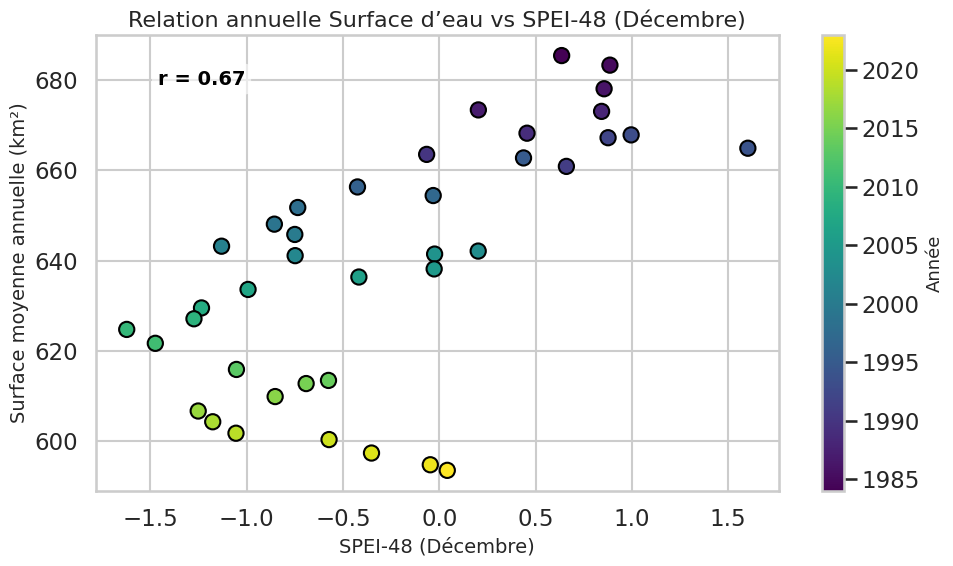

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr

def plot_water_spei_scatter_annual(df_landsat_annual, df_spei, spei_scale):
    """
    Crée un scatter plot entre la surface d'eau moyenne annuelle et le SPEI (valeur de décembre),
    avec une colorbar viridis pour l'année et affichage du coefficient de corrélation r.
    """

    if df_spei.empty or df_landsat_annual.empty:
        print("❌ Données insuffisantes pour la visualisation")
        return

    # 🔹 Préparation des données
    df_landsat = df_landsat_annual.copy()
    df_spei = df_spei.copy()

    # Extraire uniquement les valeurs de décembre
    df_spei['year'] = df_spei['date'].dt.year
    df_spei['month'] = df_spei['date'].dt.month
    df_spei_dec = df_spei[df_spei['month'] == 12].copy()

    # Fusion par année
    df_merged = pd.merge(df_landsat, df_spei_dec[['year', 'spei']], on='year', how='inner')
    df_merged = df_merged.sort_values('year')

    print(f"✅ Fusion réussie : {len(df_merged)} années communes")

    # 🔹 Calcul du coefficient de corrélation
    r, p = pearsonr(df_merged['spei'], df_merged['water_area_km2'])
    print(f"📈 Coefficient de corrélation de Pearson : r = {r:.3f} (p = {p:.4f})")

    # 🔹 Création du graphique
    sns.set_style("whitegrid")
    sns.set_context("talk")

    plt.figure(figsize=(10, 6))

    scatter = plt.scatter(
        df_merged['spei'],
        df_merged['water_area_km2'],
        c=df_merged['year'],
        cmap='viridis',
        s=120,
        edgecolors='black'
    )

    # 🔹 Ajout de la colorbar (années)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Année", fontsize=13)

    # 🔹 Ajouter le coefficient r sur le graphique
    plt.text(
        x=df_merged['spei'].min() + 0.05 * (df_merged['spei'].max() - df_merged['spei'].min()),
        y=df_merged['water_area_km2'].max() - 0.07 * (df_merged['water_area_km2'].max() - df_merged['water_area_km2'].min()),
        s=f"r = {r:.2f}",
        fontsize=14,
        color="black",
        fontweight="bold",
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
    )

    # 🔹 Titres et labels
    plt.title(f"Relation annuelle Surface d’eau vs SPEI-{spei_scale} (Décembre)", fontsize=16)
    plt.xlabel(f"SPEI-{spei_scale} (Décembre)", fontsize=14)
    plt.ylabel("Surface moyenne annuelle (km²)", fontsize=14)

    # Supprimer la légende (remplacée par colorbar)
    plt.tight_layout()

    # 🔹 Sauvegarde
    try:
        filename = f"scatter_water_spei_annual_{spei_scale}_colorbar.png"
        plt.savefig(filename, dpi=400, bbox_inches='tight')
        print(f"✅ Graphique enregistré : {filename}")
    except Exception as e:
        print(f"❌ Erreur lors de la sauvegarde : {e}")

    plt.show()

    return df_merged, r, p

spei_scale = 48  # ou 12, 24, 36
df_spei = spei_datasets[spei_scale]

df_scatter_annual, r, p = plot_water_spei_scatter_annual(df_landsat_annual, df_spei, spei_scale)
